# Determining optimal oil well location

In this project, we predict the amount of oil in wells across three regions in Russia. The data has been encoded and anonymized to maintain confidentiality.

**Our goal:** To select a region for drilling new wells to maximize profit with a probability of loss less than 2.5%.

To achieve the goal, we will build a machine learning model. The customer's requirement is to use a highly interpretable model such as linear regression.

**Data:** Three datasets, each corresponding to one region, with information on 100 000 potential spots for oil well drilling in each. Features are anonymized and all of them must be used for model training.

**Research plan:**
1. Data loading and overview.
2. Data preprocessing.
3. Exploratory data analysis.
4. Machine learning model for crude oil reserve prediction.
5. Profit calculation and risk assessment.
6. Research conclusion.

## 1. Data loading and overview

At this stage, we import the libraries necessary for the research, familiarize ourselves with the data and its format, make superficial conclusions about the data problems that we will need to fix during the preprocessing stage.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

from IPython.display import display

%config InlineBackend.figure_format = 'retina'

In [2]:
# Declare constants
RANDOM_STATE = 42
TEST_SIZE = 0.25
INTERVAL = 0.95               # confidence level

BUDGET = 10000000000          # budget of the drilling
PROFIT_PER_UNIT = 450000      # profit from 1 unit of product (1000 barrels)
WELLS_COUNT = 200             # number of wells for drilling
RISK_LIMIT = 0.025            # probability of loss, %
BOOTSTRAP_COUNT = 1000
BOOTSTRAP_SAMPLE_SIZE = 500

In [3]:
# Dataset for Region 1
data1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
display(data1.head())
data1.info()

id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
# Dataset for Region 2
data2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
display(data2.head())
data2.info()

id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
# Dataset for Region 3
data3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')
display(data3.head())
data3.info()

id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


### Summary

* The datasets for each region contain information about 100 000 potential spots for oil well drilling.
* All parameters correspond to the data description provided.
* No missing data was found in the data.
* Column names follow snake-case, no renaming required.
* The `id` column is alphanumeric and requires a check for duplicates.

## 2. Data preprocessing

At this stage, we clean the data, make it more suitable for research by addressing issues such as:
* duplicates (explicit and implicit);
* missind data;
* incorrect data format in cells;
* incorrect data.

First of all, we will check on explicit duplicates (identical rows).

In [6]:
print('Explicit duplicates:')
print('data1:', data1.duplicated().sum())
print('data2:', data2.duplicated().sum())
print('data3:', data3.duplicated().sum())

Explicit duplicates:
data1: 0
data2: 0
data3: 0


Next, we will check on implicit duplicates - rows the same `id`.

In [7]:
print('Duplicated IDs:')
print('data1:', data1.duplicated(subset=['id']).sum())
print('data2:', data2.duplicated(subset=['id']).sum())
print('data3:', data3.duplicated(subset=['id']).sum())

Duplicated IDs:
data1: 10
data2: 4
data3: 4


In [8]:
# Check duplicated rows
data1[data1.duplicated(subset=['id'])]
dup_ids = data1[data1.duplicated(subset=['id'])]['id'].to_list()
data1[data1['id'].isin(dup_ids)].sort_values(by='id')

id        f0        f1         f2     product
66136  74z30  1.084962 -0.312358   6.990771  127.643327
64022  74z30  0.741456  0.459229   5.153109  140.771492
51970  A5aEY -0.180335  0.935548  -2.094773   33.020205
3389   A5aEY -0.039949  0.156872   0.209861   89.249364
69163  AGS9W -0.933795  0.116194  -3.655896   19.230453
42529  AGS9W  1.454747 -0.479651   0.683380  126.370504
931    HZww2  0.755284  0.368511   1.863211   30.681774
7530   HZww2  1.061194 -0.373969  10.430210  158.828695
63593  QcMuo  0.635635 -0.473422   0.862670   64.578675
1949   QcMuo  0.506563 -0.323775  -2.215583   75.496502
75715  Tdehs  0.112079  0.430296   3.218993   60.964018
21426  Tdehs  0.829407  0.298807  -0.049563   96.035308
92341  TtcGQ  0.110711  1.022689   0.911381  101.318008
60140  TtcGQ  0.569276 -0.104876   6.440215   85.350186
89582  bsk9y  0.398908 -0.400253  10.122376  163.433078
97785  bsk9y  0.378429  0.005837   0.160827  160.637302
41724  bxg6G -0.823752  0.546319   3.630479   93.007798
1364   bxg6G  0.411645  0.856830  -3.653440   73.604260
16633  fiKDv  0.157341  1.028359   5.585586   95.817889
90815  fiKDv  0.049883  0.841313   6.394613  137.346586

Rows with the same `id` have different parameters.

In [9]:
# Remove duplicates keeping last copy
data1 = data1.drop_duplicates(subset=['id'], keep='last')
data2 = data2.drop_duplicates(subset=['id'], keep='last')
data3 = data3.drop_duplicates(subset=['id'], keep='last')

In [10]:
# Set id as index column
data1 = data1.set_index('id')
data2 = data2.set_index('id')
data3 = data3.set_index('id')

# Set DF names to use in plot titles
data1.name = 'Region 1'
data2.name = 'Region 2'
data3.name = 'Region 3'

### Summary

Implicit duplicates were detected — records with the same `id` but different parameters. This could either be an error in the `id` or multiple measurements with varying results. Since we did not have the opportunity to clarify this issue, and the duplicate data accounted for less than 0.01%, we decided to remove the duplicates, keeping the most recent value encountered.

## 3. Exploratory data analysis

At this stage, we will explore the distribution of features, identify and eliminate anomalies in the data, and search for relationships between features.

Before we start, we will create functions for diagrams and plots to avoid repeating the same code multiple times.

In [11]:
# Function for density histograms
def draw_norm_histogram(data, column, share=False):
    if len(data) == 1:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
        ax.set_title(f'Density histogram of the {column} feature. {data[0].name}',
                     fontweight='semibold')
        ax.set_xlabel(f'Feature: {column}')
        ax.set_ylabel('Density')
        ax.grid()
        sns.histplot(data[0],
                     x=column,
                     stat='density',
                     common_norm=False,
                     ax=ax)
    
    elif (len(data)) == 2 or (len(data) == 3):
        fig, ax = plt.subplots(nrows=1, ncols=len(data), figsize=(18,6), sharex=share, sharey=share)
        if share == True:
            plt.suptitle(f'Density histogram of the {column} feature (single scale)',
                         fontweight='semibold')
        else:
            plt.suptitle(f'Density histogram of the {column} feature (different scales)',
                         fontweight='semibold')
        for i in range(len(data)):
            ax[i].set_title(data[i].name,
                            fontweight='semibold')
            ax[i].set_xlabel(f'Feature: {column}')
            ax[i].set_ylabel('Density')
            ax[i].grid()
            sns.histplot(data[i],
                         x=column,
                         stat='density',
                         common_norm=False,
                         ax=ax[i])
    else:
        return 'Error: number of elements in data must be between 1 and 3.'
        
    plt.show()

In [12]:
# Function for descriptive statistics
def show_description(data, column):
    stats_df = pd.DataFrame()
    for i in range(len(data)):
        stats_df[data[i].name] = pd.Series(data[i][column].describe().round(2))
    display(stats_df)

In [13]:
# Function for boxplots
def draw_boxplot(data, column):
    if len(data) == 1:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,10))
        ax.set_title(f'Boxplot of the {column} feature. {data[0].name}',
                     fontweight='semibold')
        ax.grid()
        sns.boxplot(y=column, data=data[0], ax=ax)
    
    elif (len(data)) == 2 or (len(data) == 3):
        fig, ax = plt.subplots(nrows=1, ncols=len(data), figsize=(18,10), sharey=True)
        plt.suptitle(f'Boxplots of the {column} feature',
                     fontweight='semibold')
        for i in range(len(data)):
            ax[i].set_title(data[i].name,
                            fontweight='semibold')
            ax[i].set_xlabel(f'Feature: {column}')
            ax[i].set_ylabel('Density')
            ax[i].grid()
            sns.boxplot(y=column, data=data[i], ax=ax[i])
    else:
        return 'Error: number of elements in data must be between 1 and 3.'
        
    plt.show()

In [14]:
# Function for QQ-plot
def draw_qq_plot(data, column):
    if len(data) == 1:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
        ax.set_title(f'Quantile-quantile plot of the {column} feature. {data[0].name}',
                     fontweight='semibold')
        ax.grid()
        sm.qqplot(data[0][column], line='45', fit=True, ax=ax)
    
    elif (len(data)) == 2 or (len(data) == 3):
        fig, ax = plt.subplots(nrows=1, ncols=len(data), figsize=(18,6), sharey=True)
        plt.suptitle(f'Quantile-quantile plot of the {column} feature',
                     fontweight='semibold')
        for i in range(len(data)):
            ax[i].set_title(data[i].name,
                            fontweight='semibold')
            sm.qqplot(data[i][column], line='45', fit=True, ax=ax[i])
    else:
        return 'Error: number of elements in data must be between 1 and 3.'
     
    plt.show()

In [15]:
# Function for Spearman's correlation matrix
def draw_corr_matrix(data):
    if len(data) == 1:
        corr = data[0].corr(method='spearman')
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
        ax.set_title(f"Spearman's correlation matrix. {data[0].name}",
                     fontweight='semibold')
        sns.heatmap(corr,
                    xticklabels=corr.columns.values,
                    yticklabels=corr.columns.values,
                    vmin=-1,
                    vmax=1,
                    annot=True,
                    fmt='.2',
                    cmap='Blues',
                    cbar=True,
                    ax=ax)
    
    elif (len(data)) == 2 or (len(data) == 3):
        fig, ax = plt.subplots(nrows=1, ncols=len(data), figsize=(18,6))
        plt.suptitle("Spearman's correlation matrix",
                     fontweight='semibold')
        for i in range(len(data)):
            corr = data[i].corr(method='spearman')
            ax[i].set_title(data[i].name,
                            fontweight='semibold')
            sns.heatmap(corr,
                        xticklabels=corr.columns.values,
                        yticklabels=corr.columns.values,
                        vmin=-1,
                        vmax=1,
                        annot=True,
                        fmt='.2',
                        cmap='Blues',
                        cbar=False,
                        ax=ax[i])
    else:
        return 'Error: number of elements in data must be between 1 and 3.'
        
    plt.show()

### Feature `f0`

First, we will look at density histograms for each region independently, without aligning them to a single coordinate grid, to examine the distribution of the feature in each region.

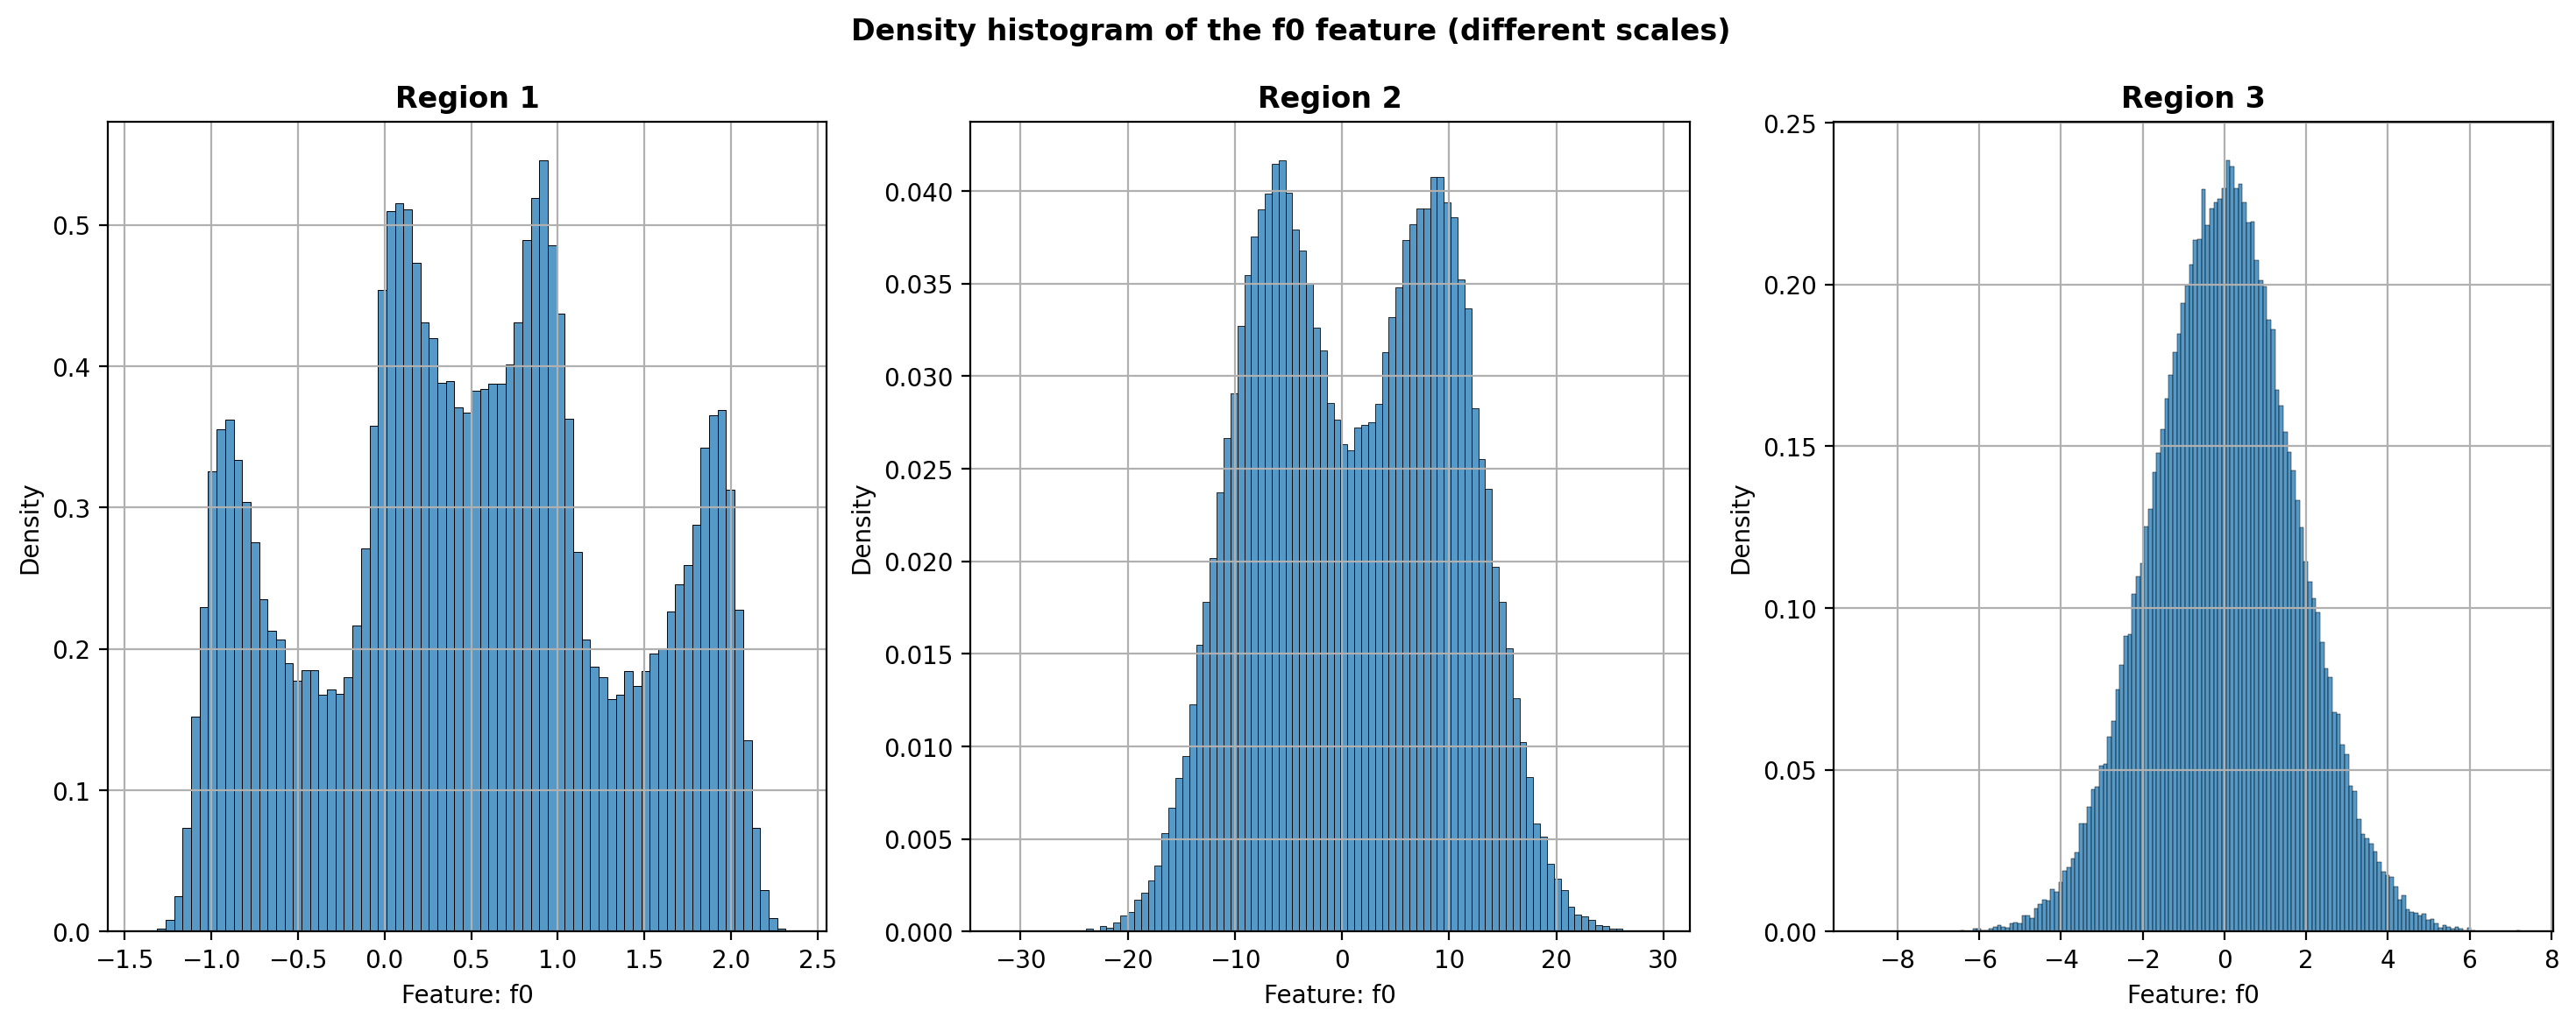

In [16]:
draw_norm_histogram(data=[data1, data2, data3], column='f0')

Next, we will overlay the histograms on a single coordinate grid to visually assess the differences in distributions across the three regions. We will also display descriptive statistics to numerically evaluate the differences.

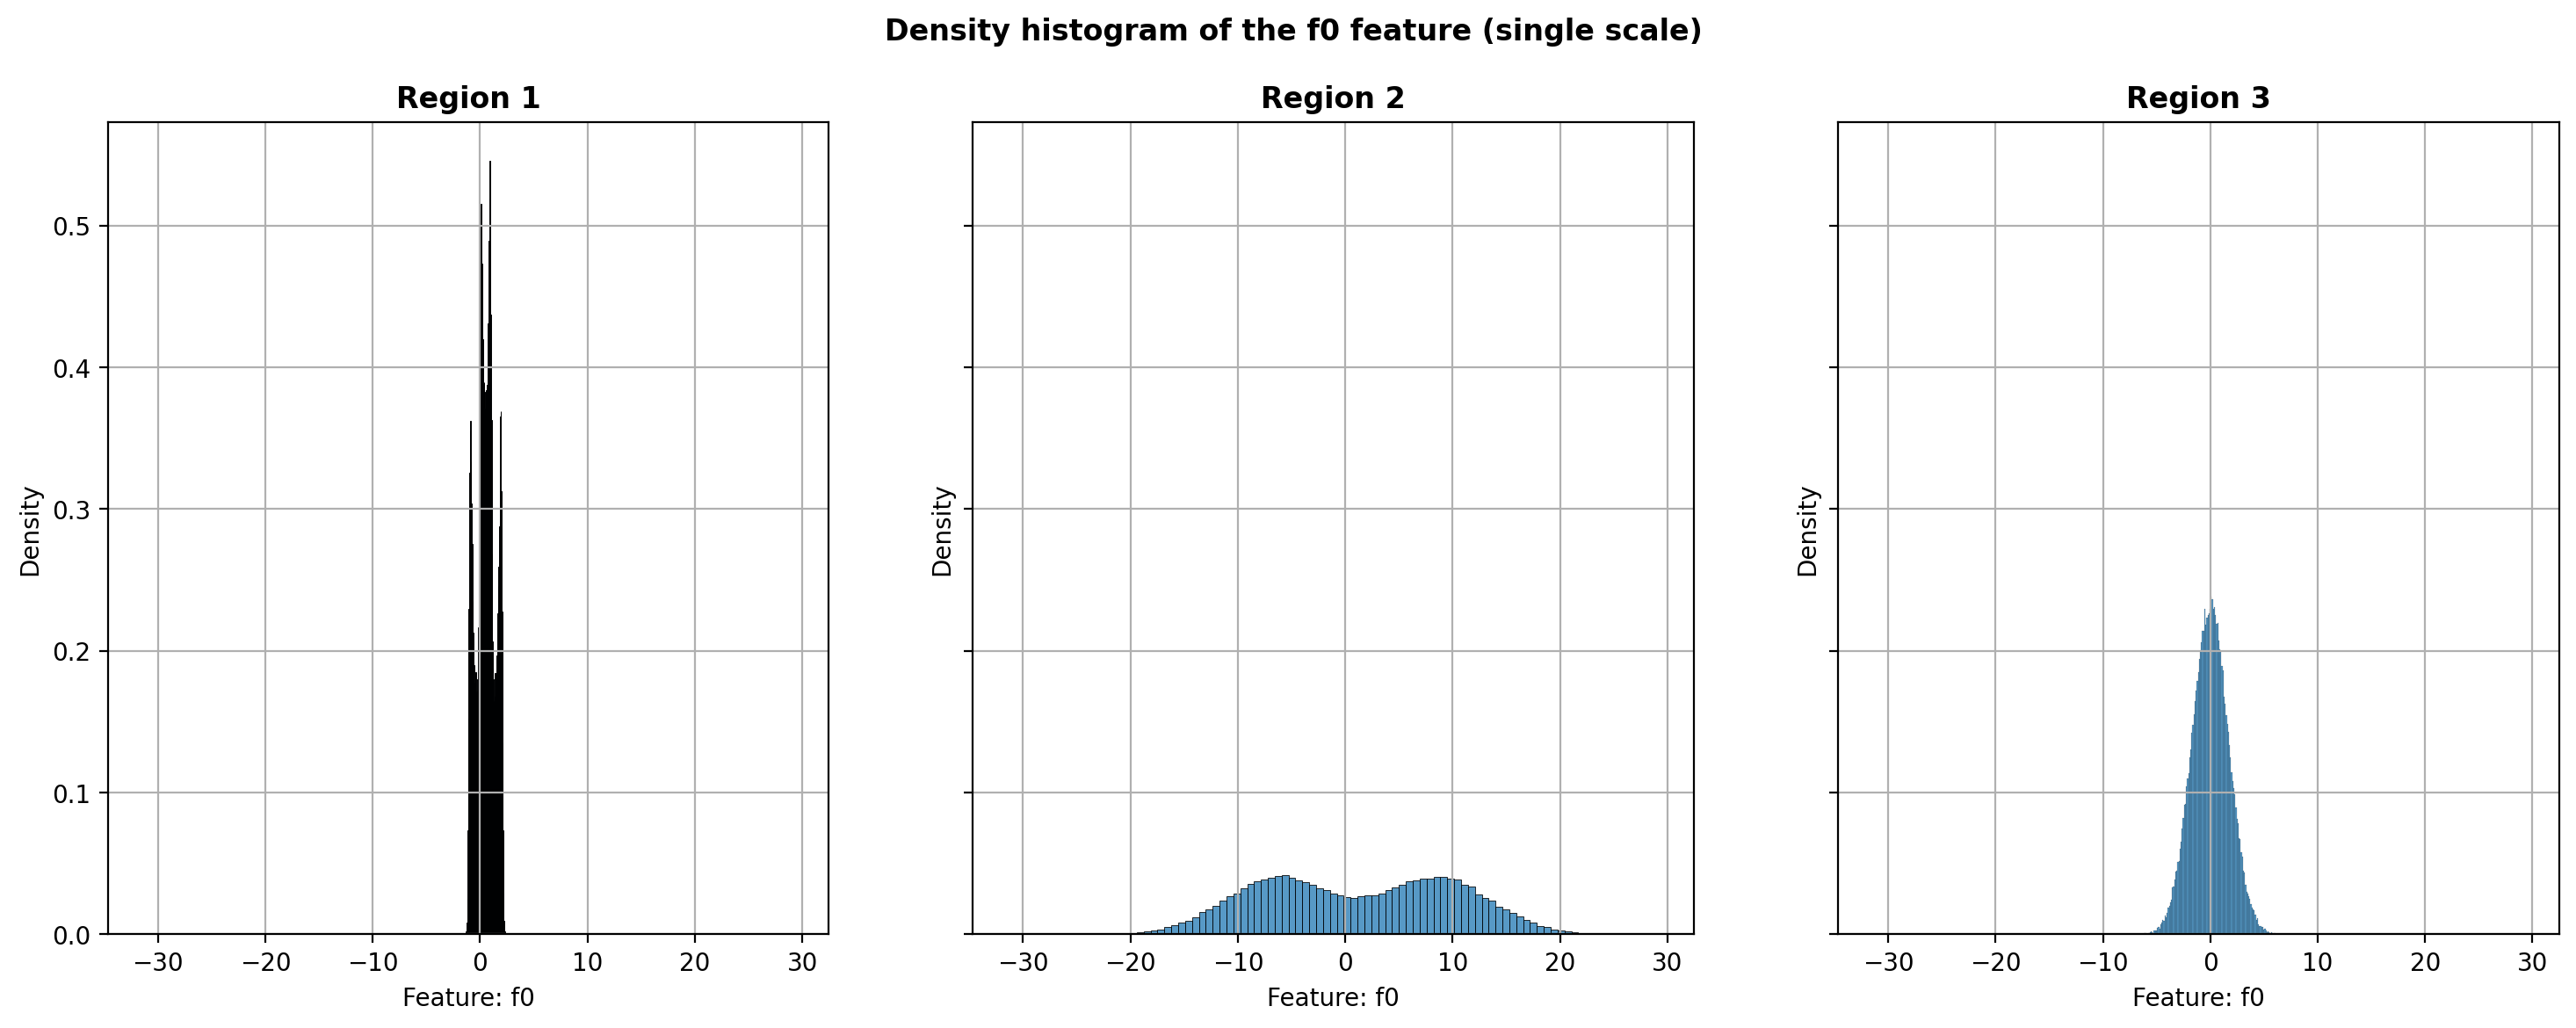

In [17]:
draw_norm_histogram(data=[data1, data2, data3], column='f0', share=True)

In [18]:
show_description(data=[data1, data2, data3], column='f0')

Region 1  Region 2  Region 3
count  99990.00  99996.00  99996.00
mean       0.50      1.14      0.00
std        0.87      8.97      1.73
min       -1.41    -31.61     -8.76
25%       -0.07     -6.30     -1.16
50%        0.50      1.15      0.01
75%        1.07      8.62      1.16
max        2.36     29.42      7.24

Let's look at the boxplots to check for outliers.

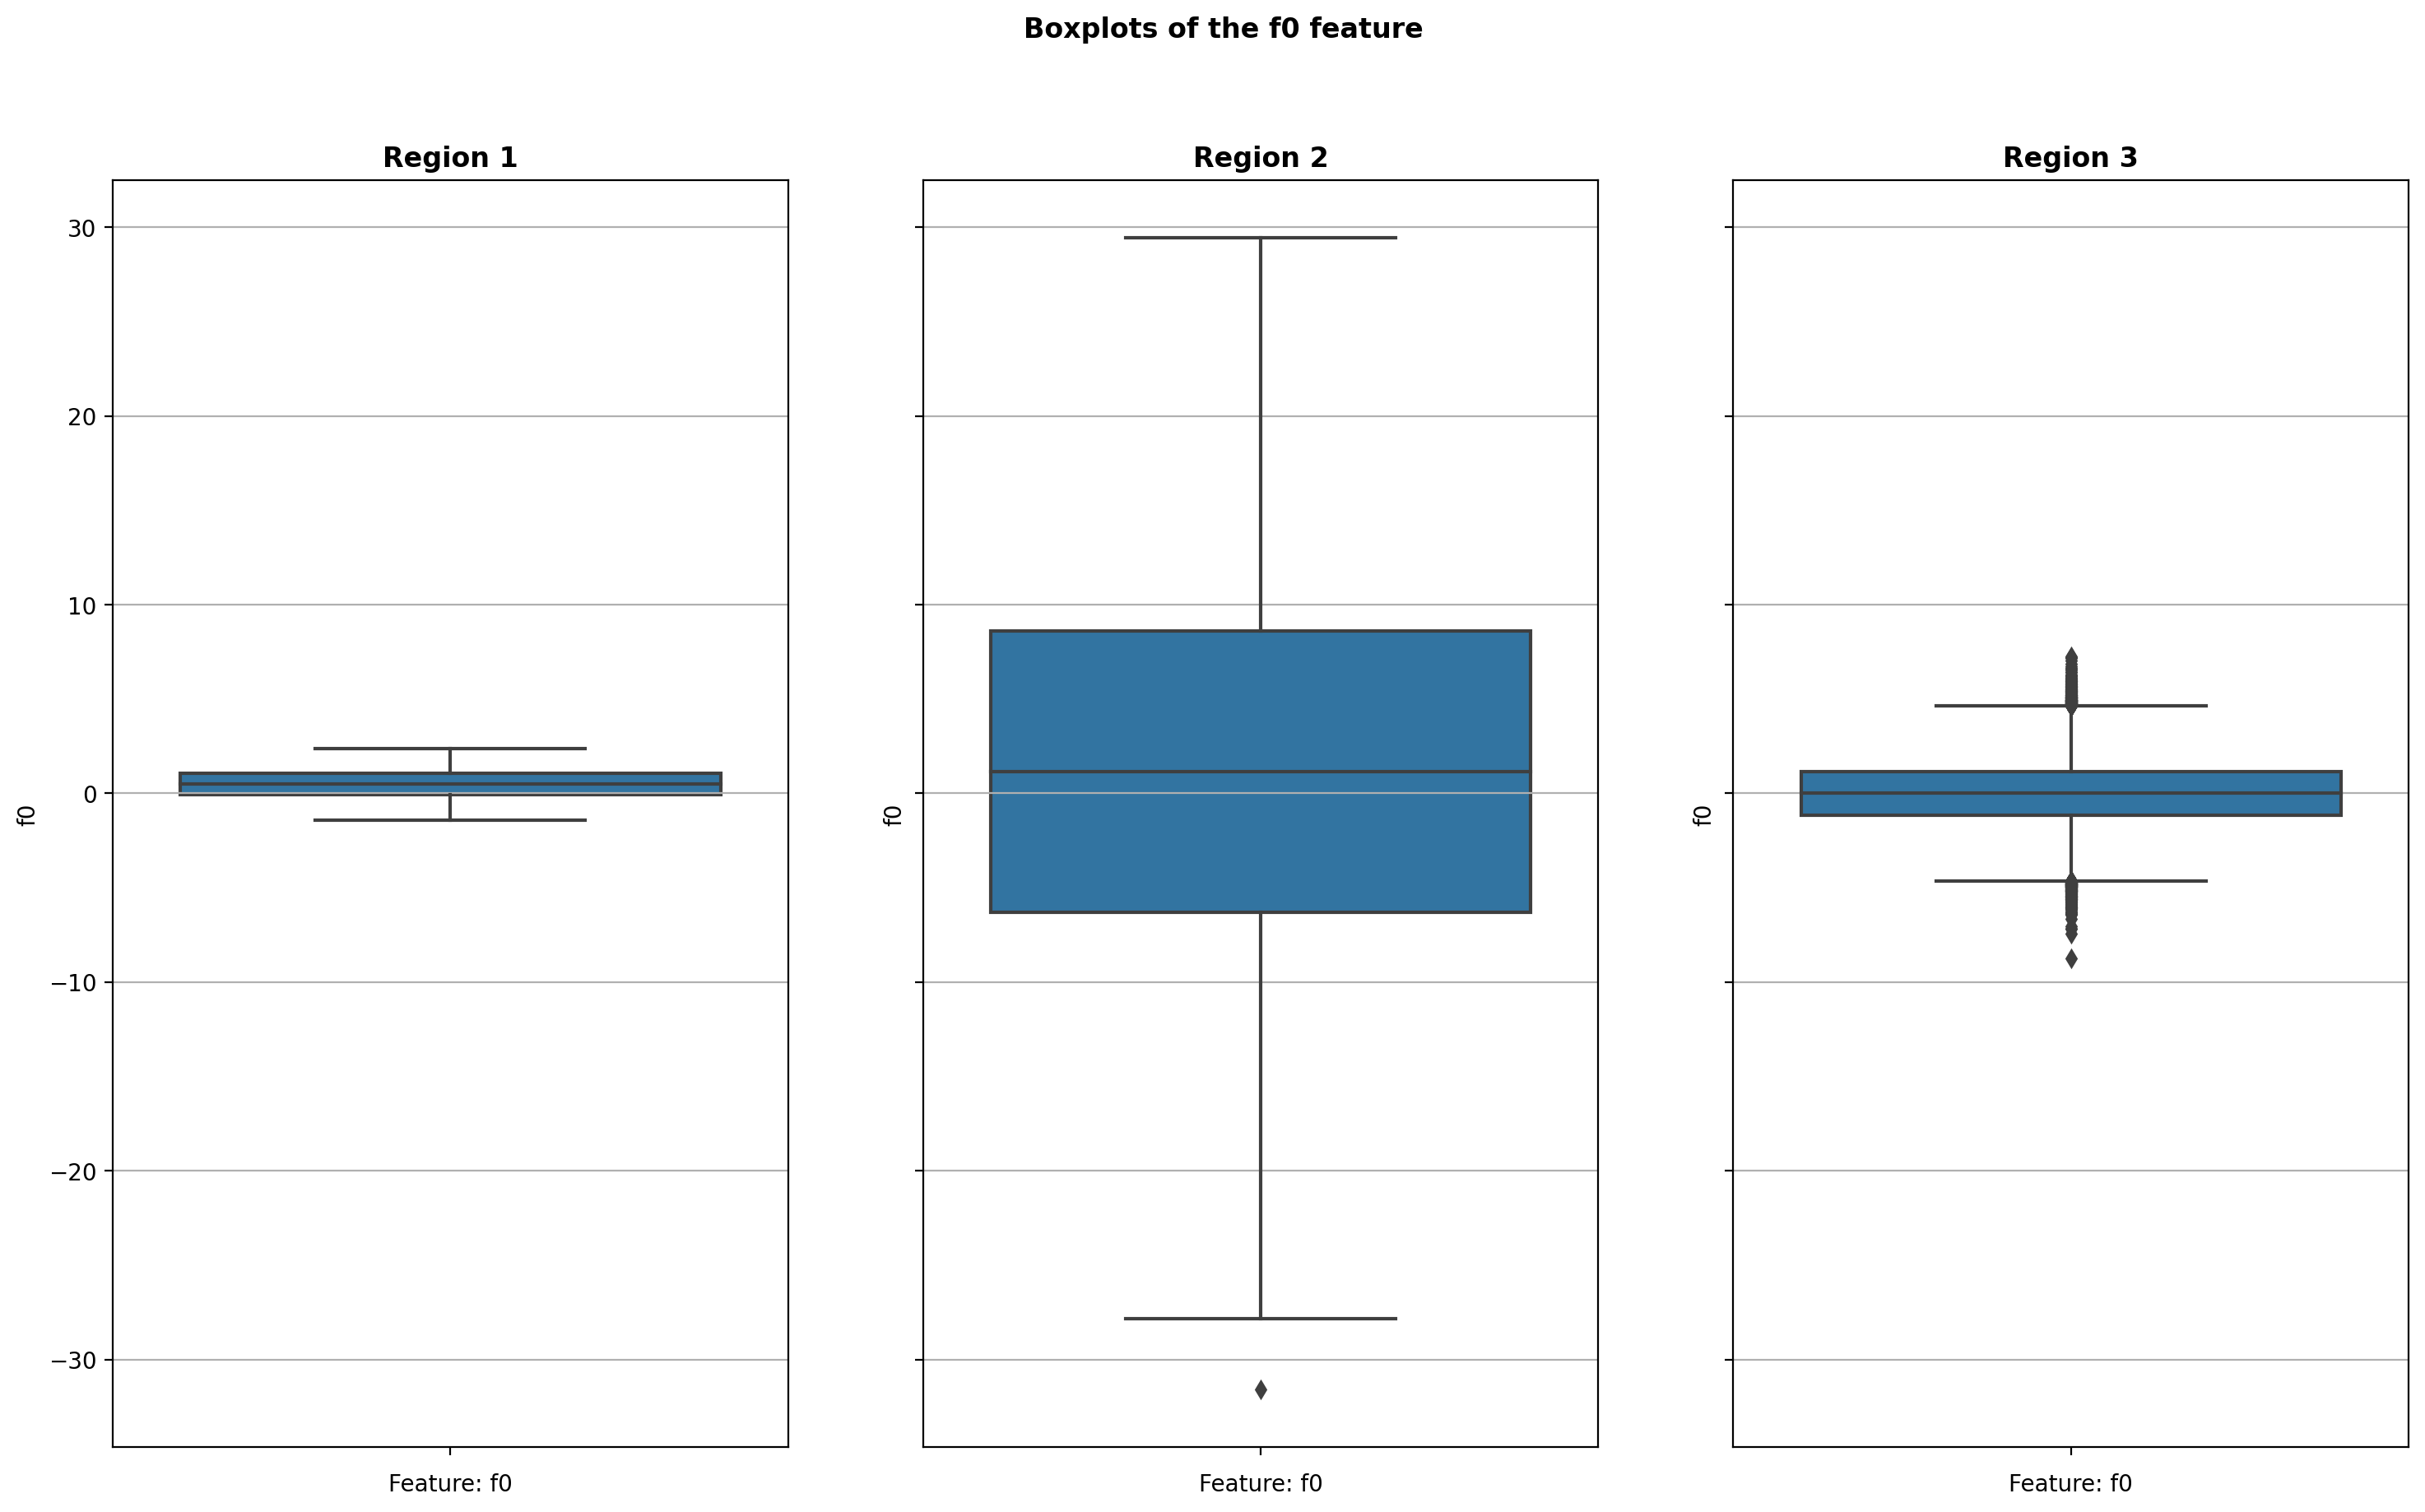

In [19]:
draw_boxplot(data=[data1, data2, data3], column='f0')

Let's look at the QQ-plots to determine whether the distributions are normal or non-normal.

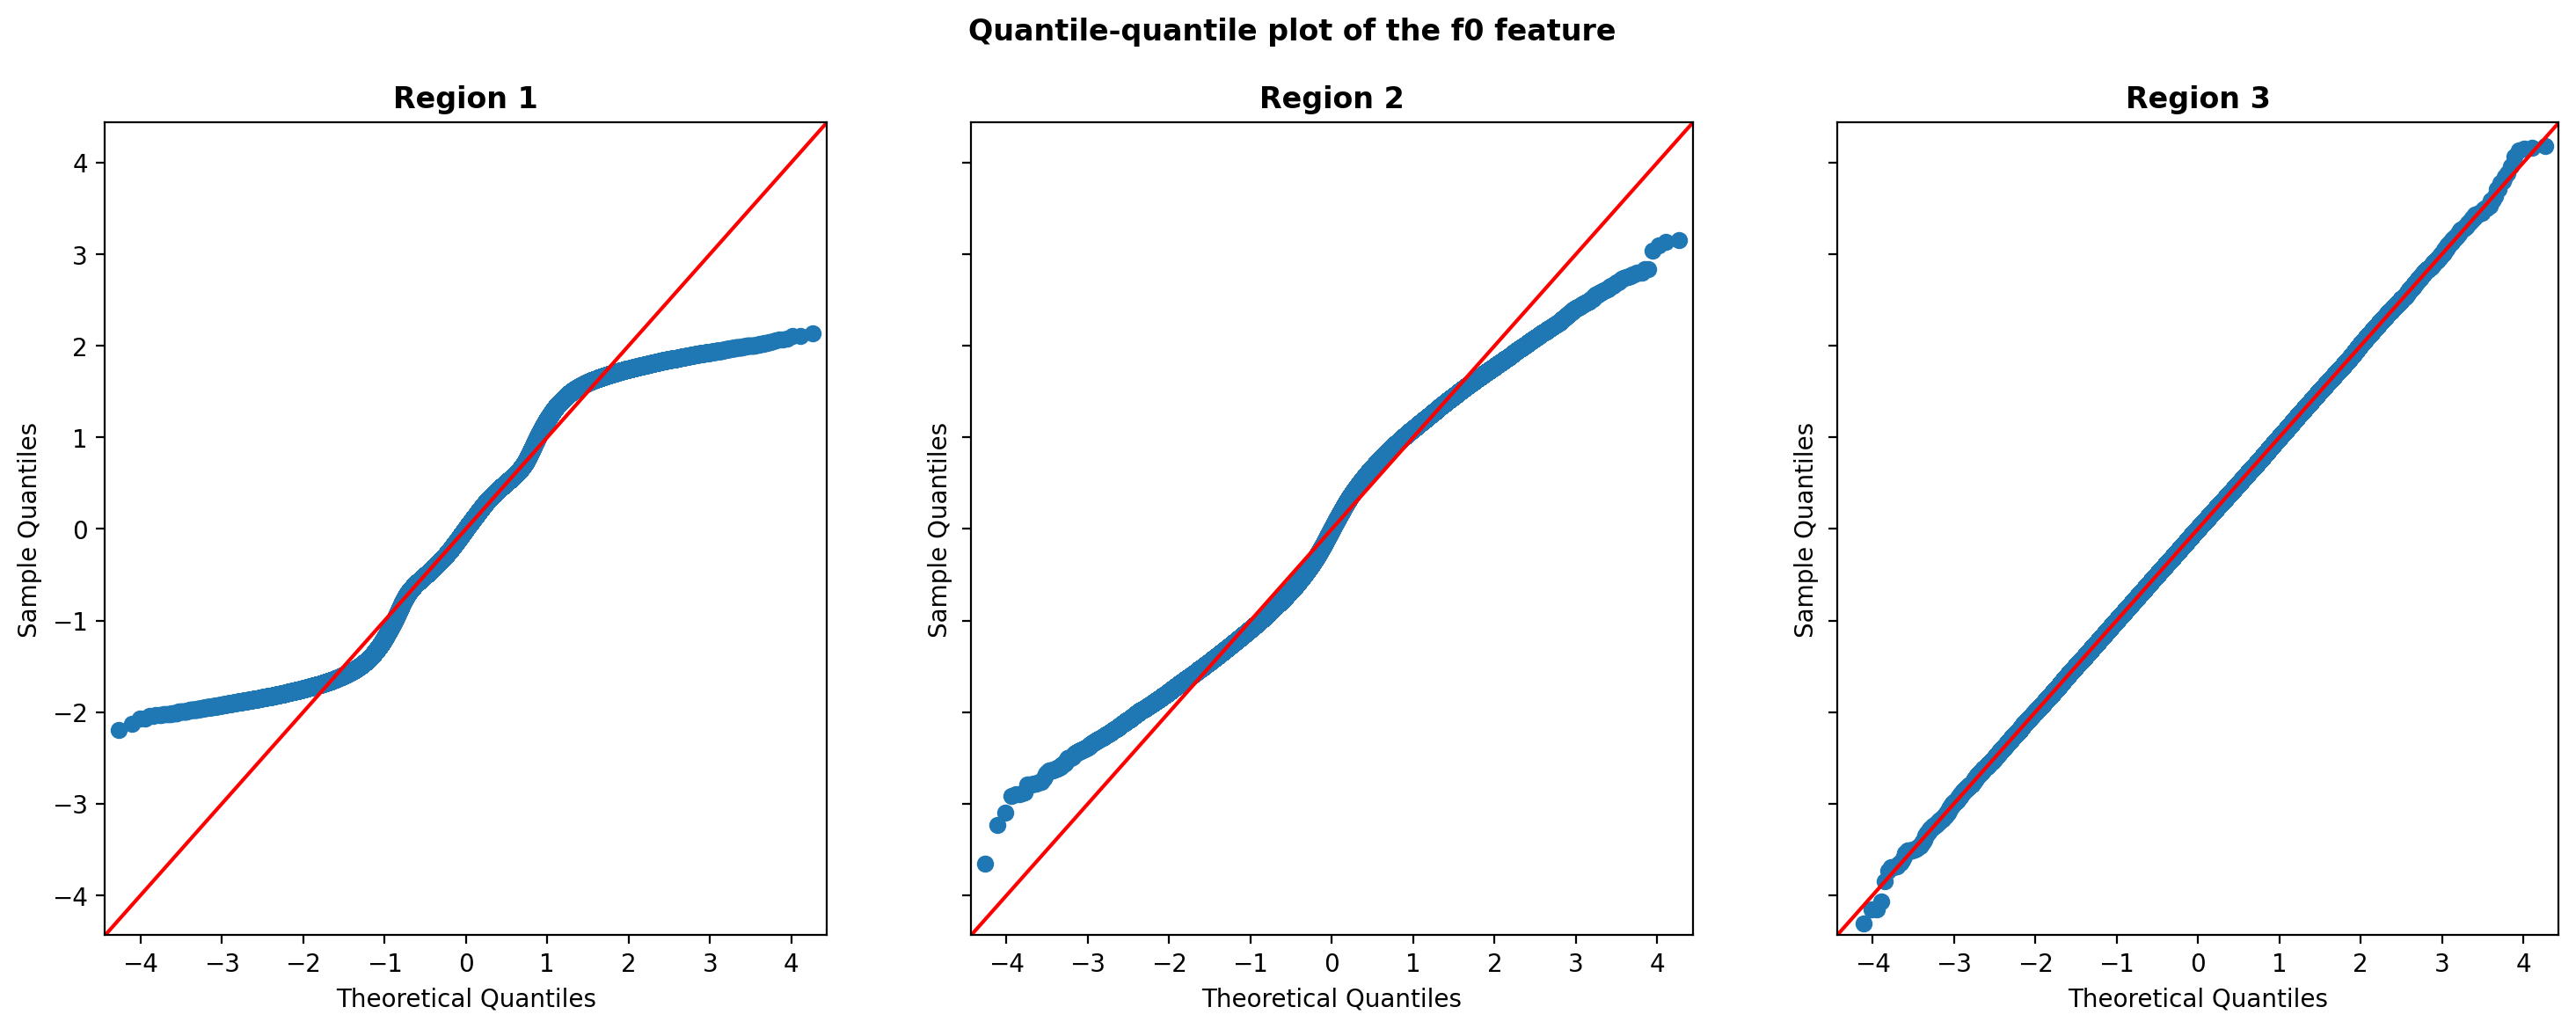

In [20]:
draw_qq_plot(data=[data1, data2, data3], column='f0')

**Observations:**

* The feature `f0` in the first and second regions is not normally distributed and exhibits a multimodal distribution.
* In the third region, the feature `f0` is normally distributed.
* The numerical values of the feature also differ across the regions.
* In the second region, the range of values is much wider than in the first and third regions.
* Additionally, outliers are observed in the third region.

### Feature `f1`

Let's repeat the same actions for the `f1` feature.

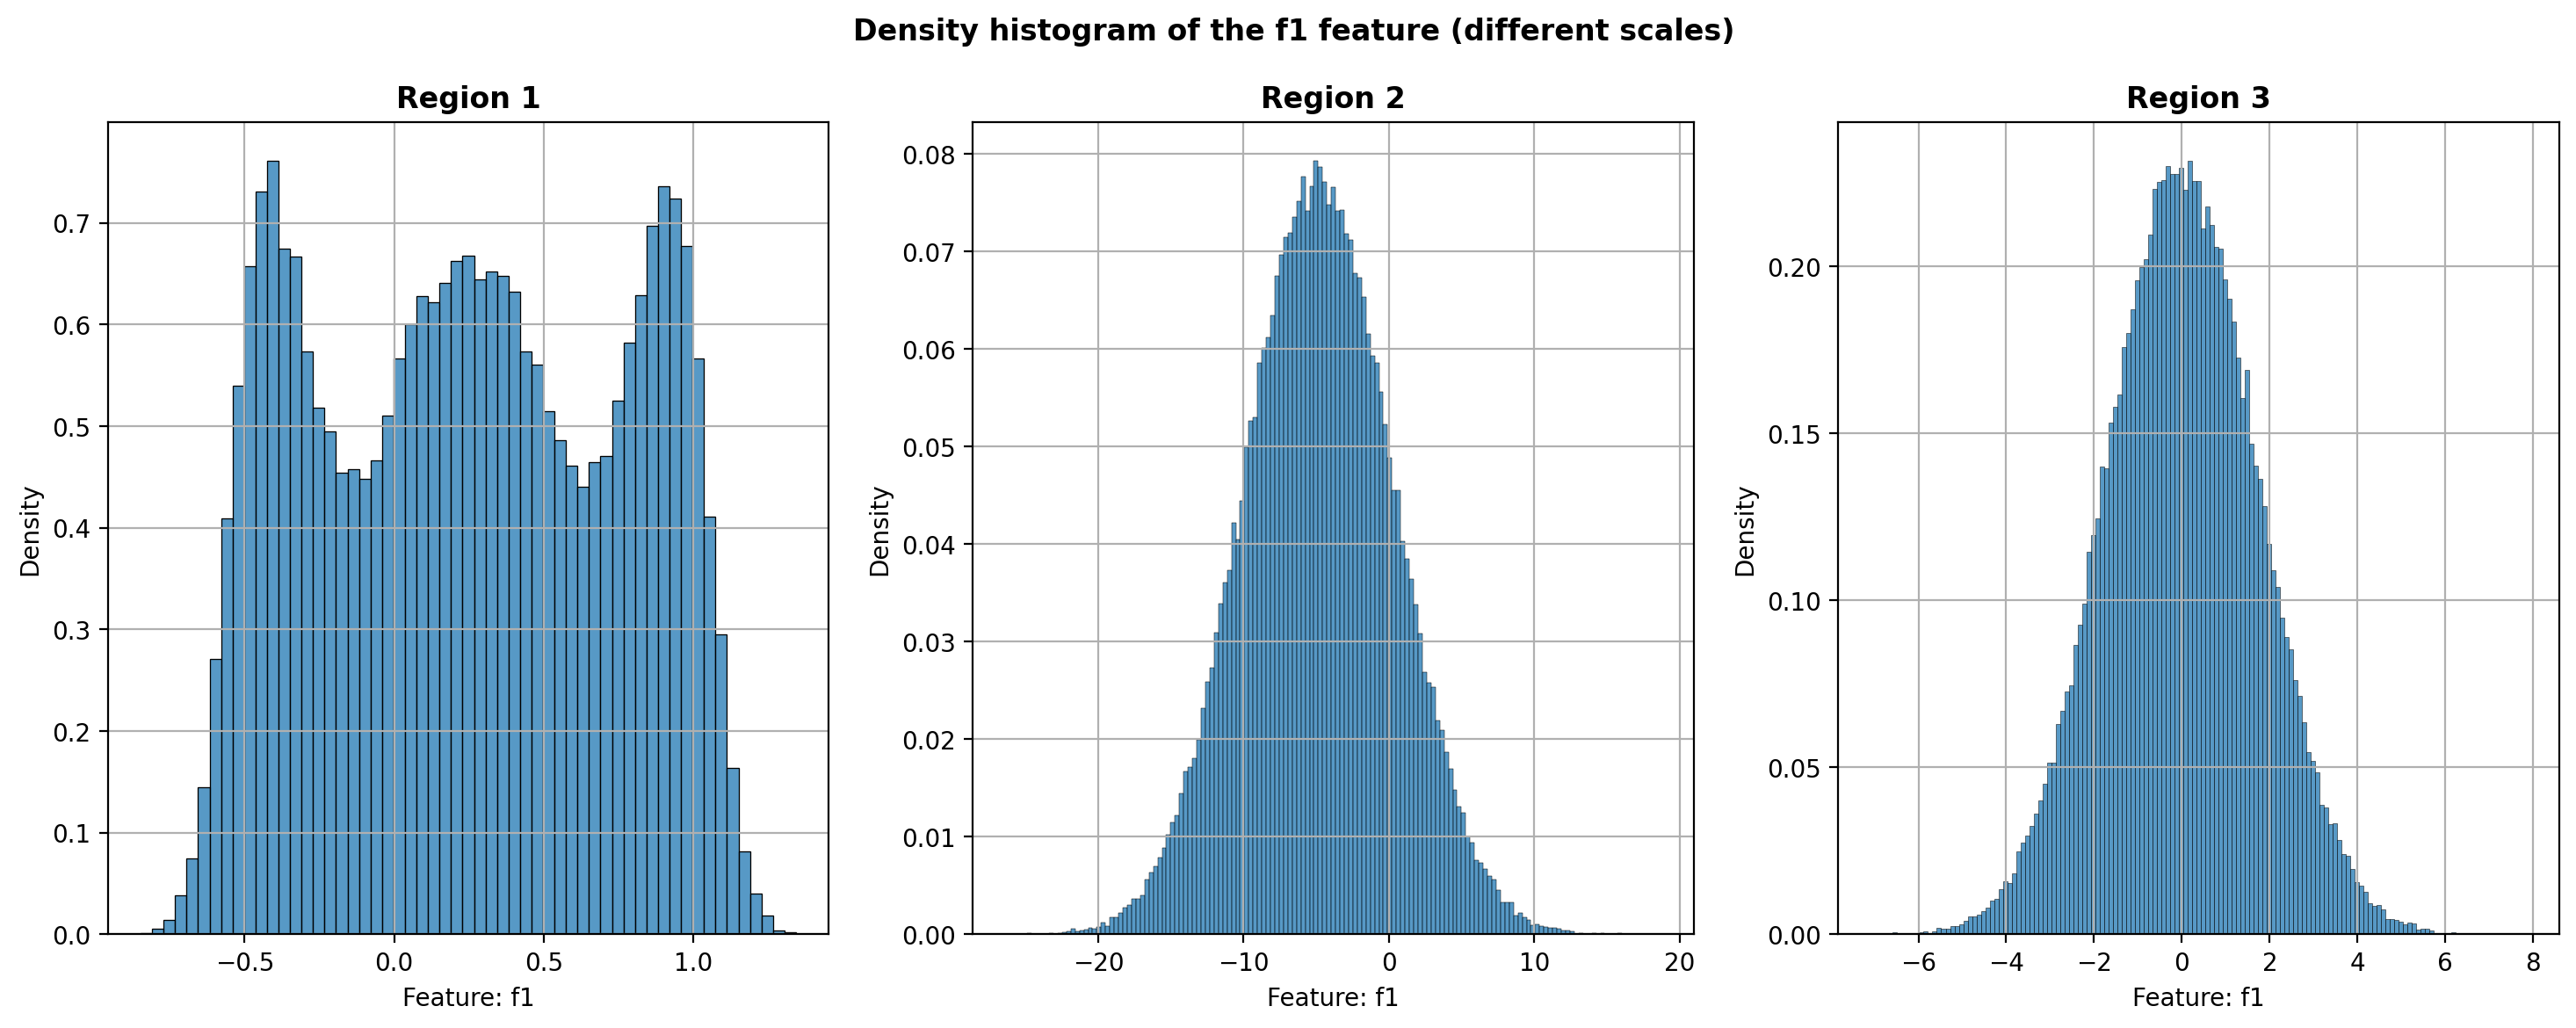

In [21]:
draw_norm_histogram(data=[data1, data2, data3], column='f1')

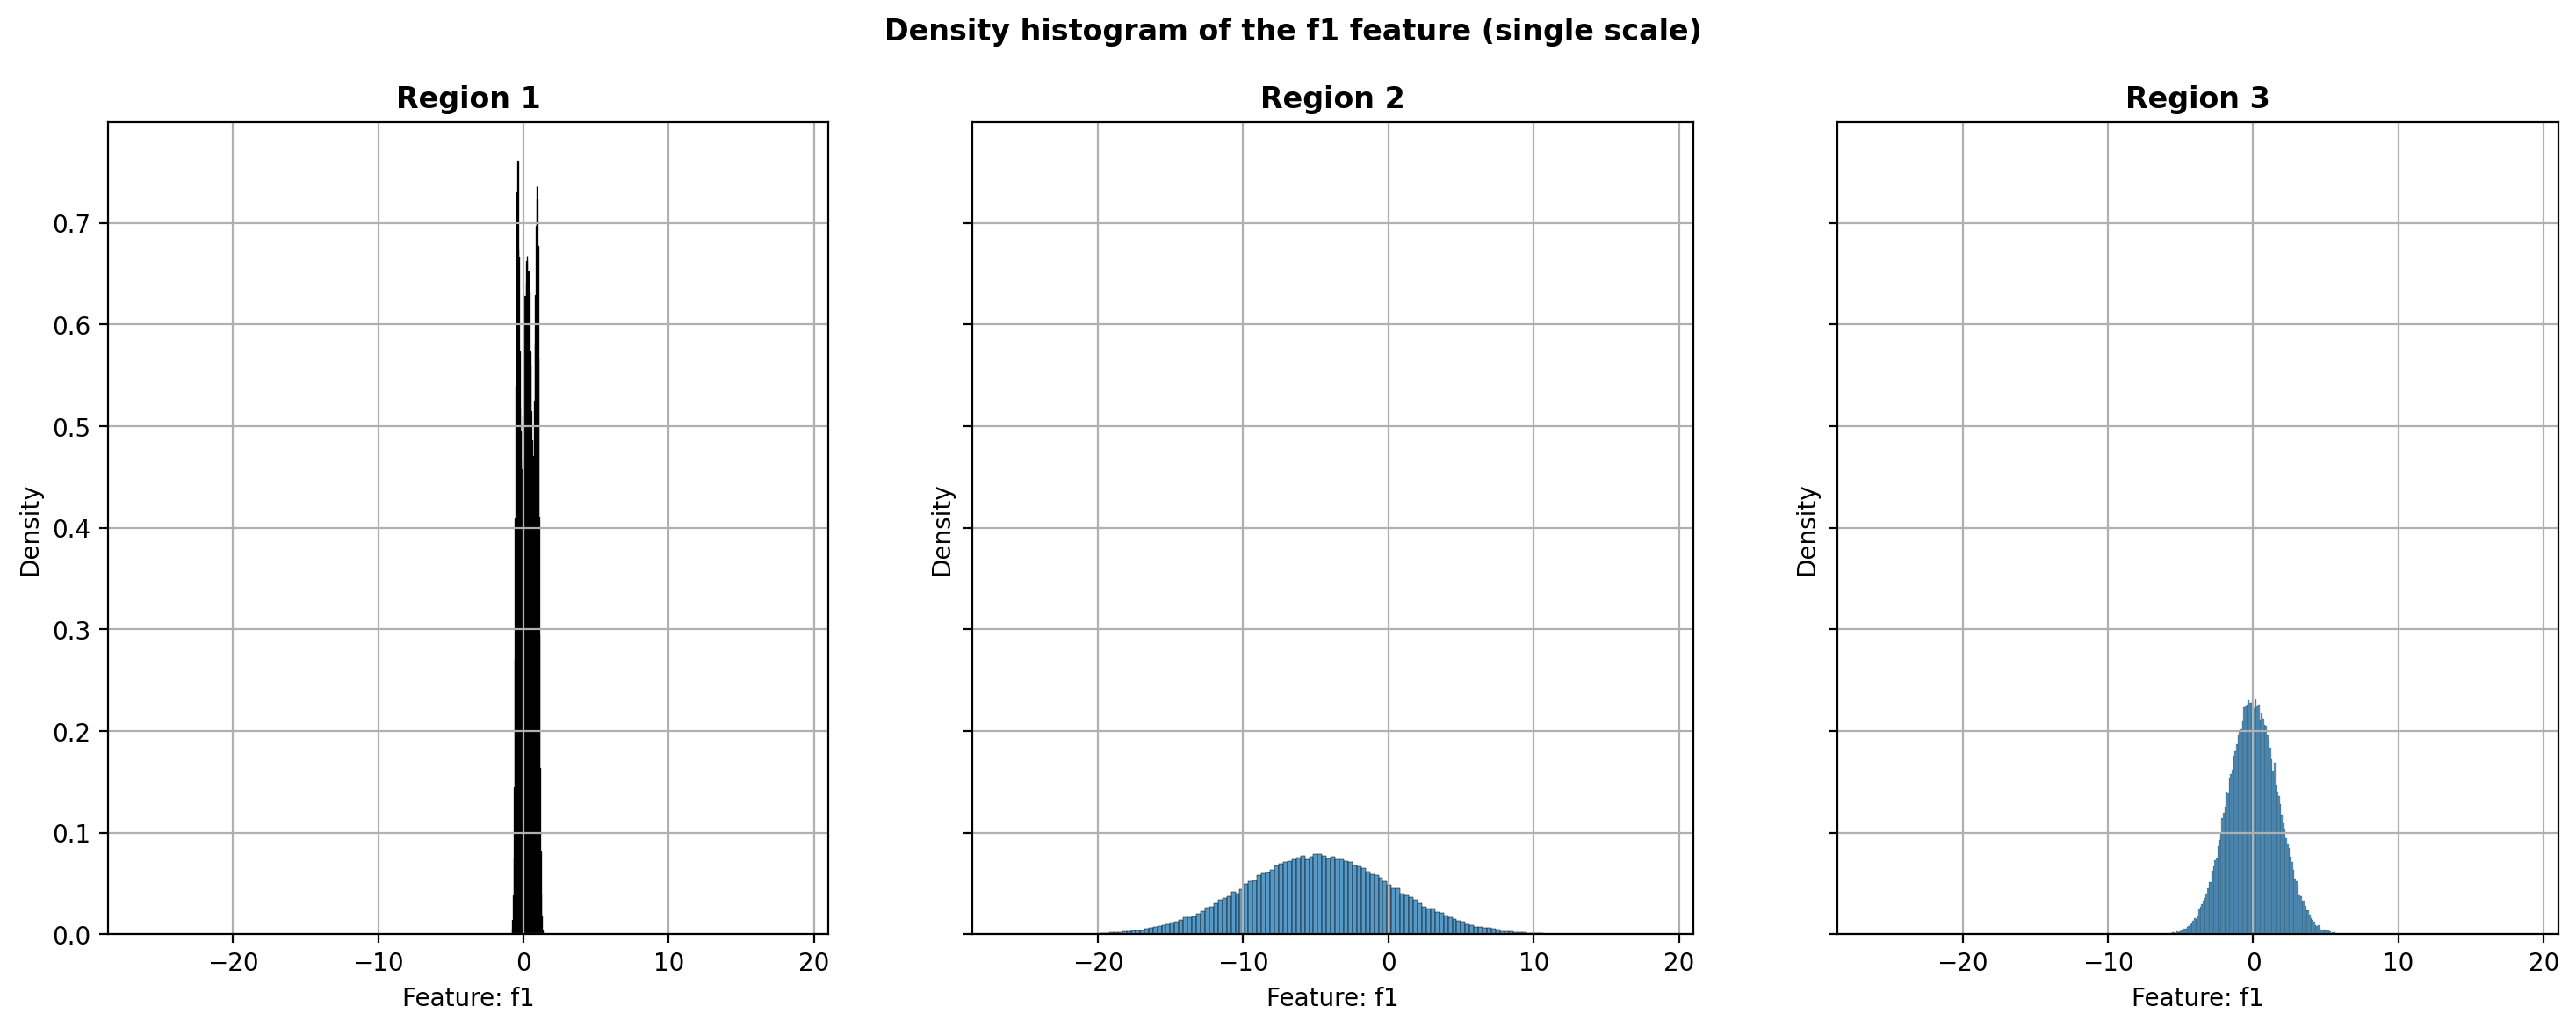

In [22]:
draw_norm_histogram(data=[data1, data2, data3], column='f1', share=True)

In [23]:
show_description(data=[data1, data2, data3], column='f1')

Region 1  Region 2  Region 3
count  99990.00  99996.00  99996.00
mean       0.25     -4.80     -0.00
std        0.50      5.12      1.73
min       -0.85    -26.36     -7.08
25%       -0.20     -8.27     -1.17
50%        0.25     -4.81     -0.01
75%        0.70     -1.33      1.16
max        1.34     18.73      7.84

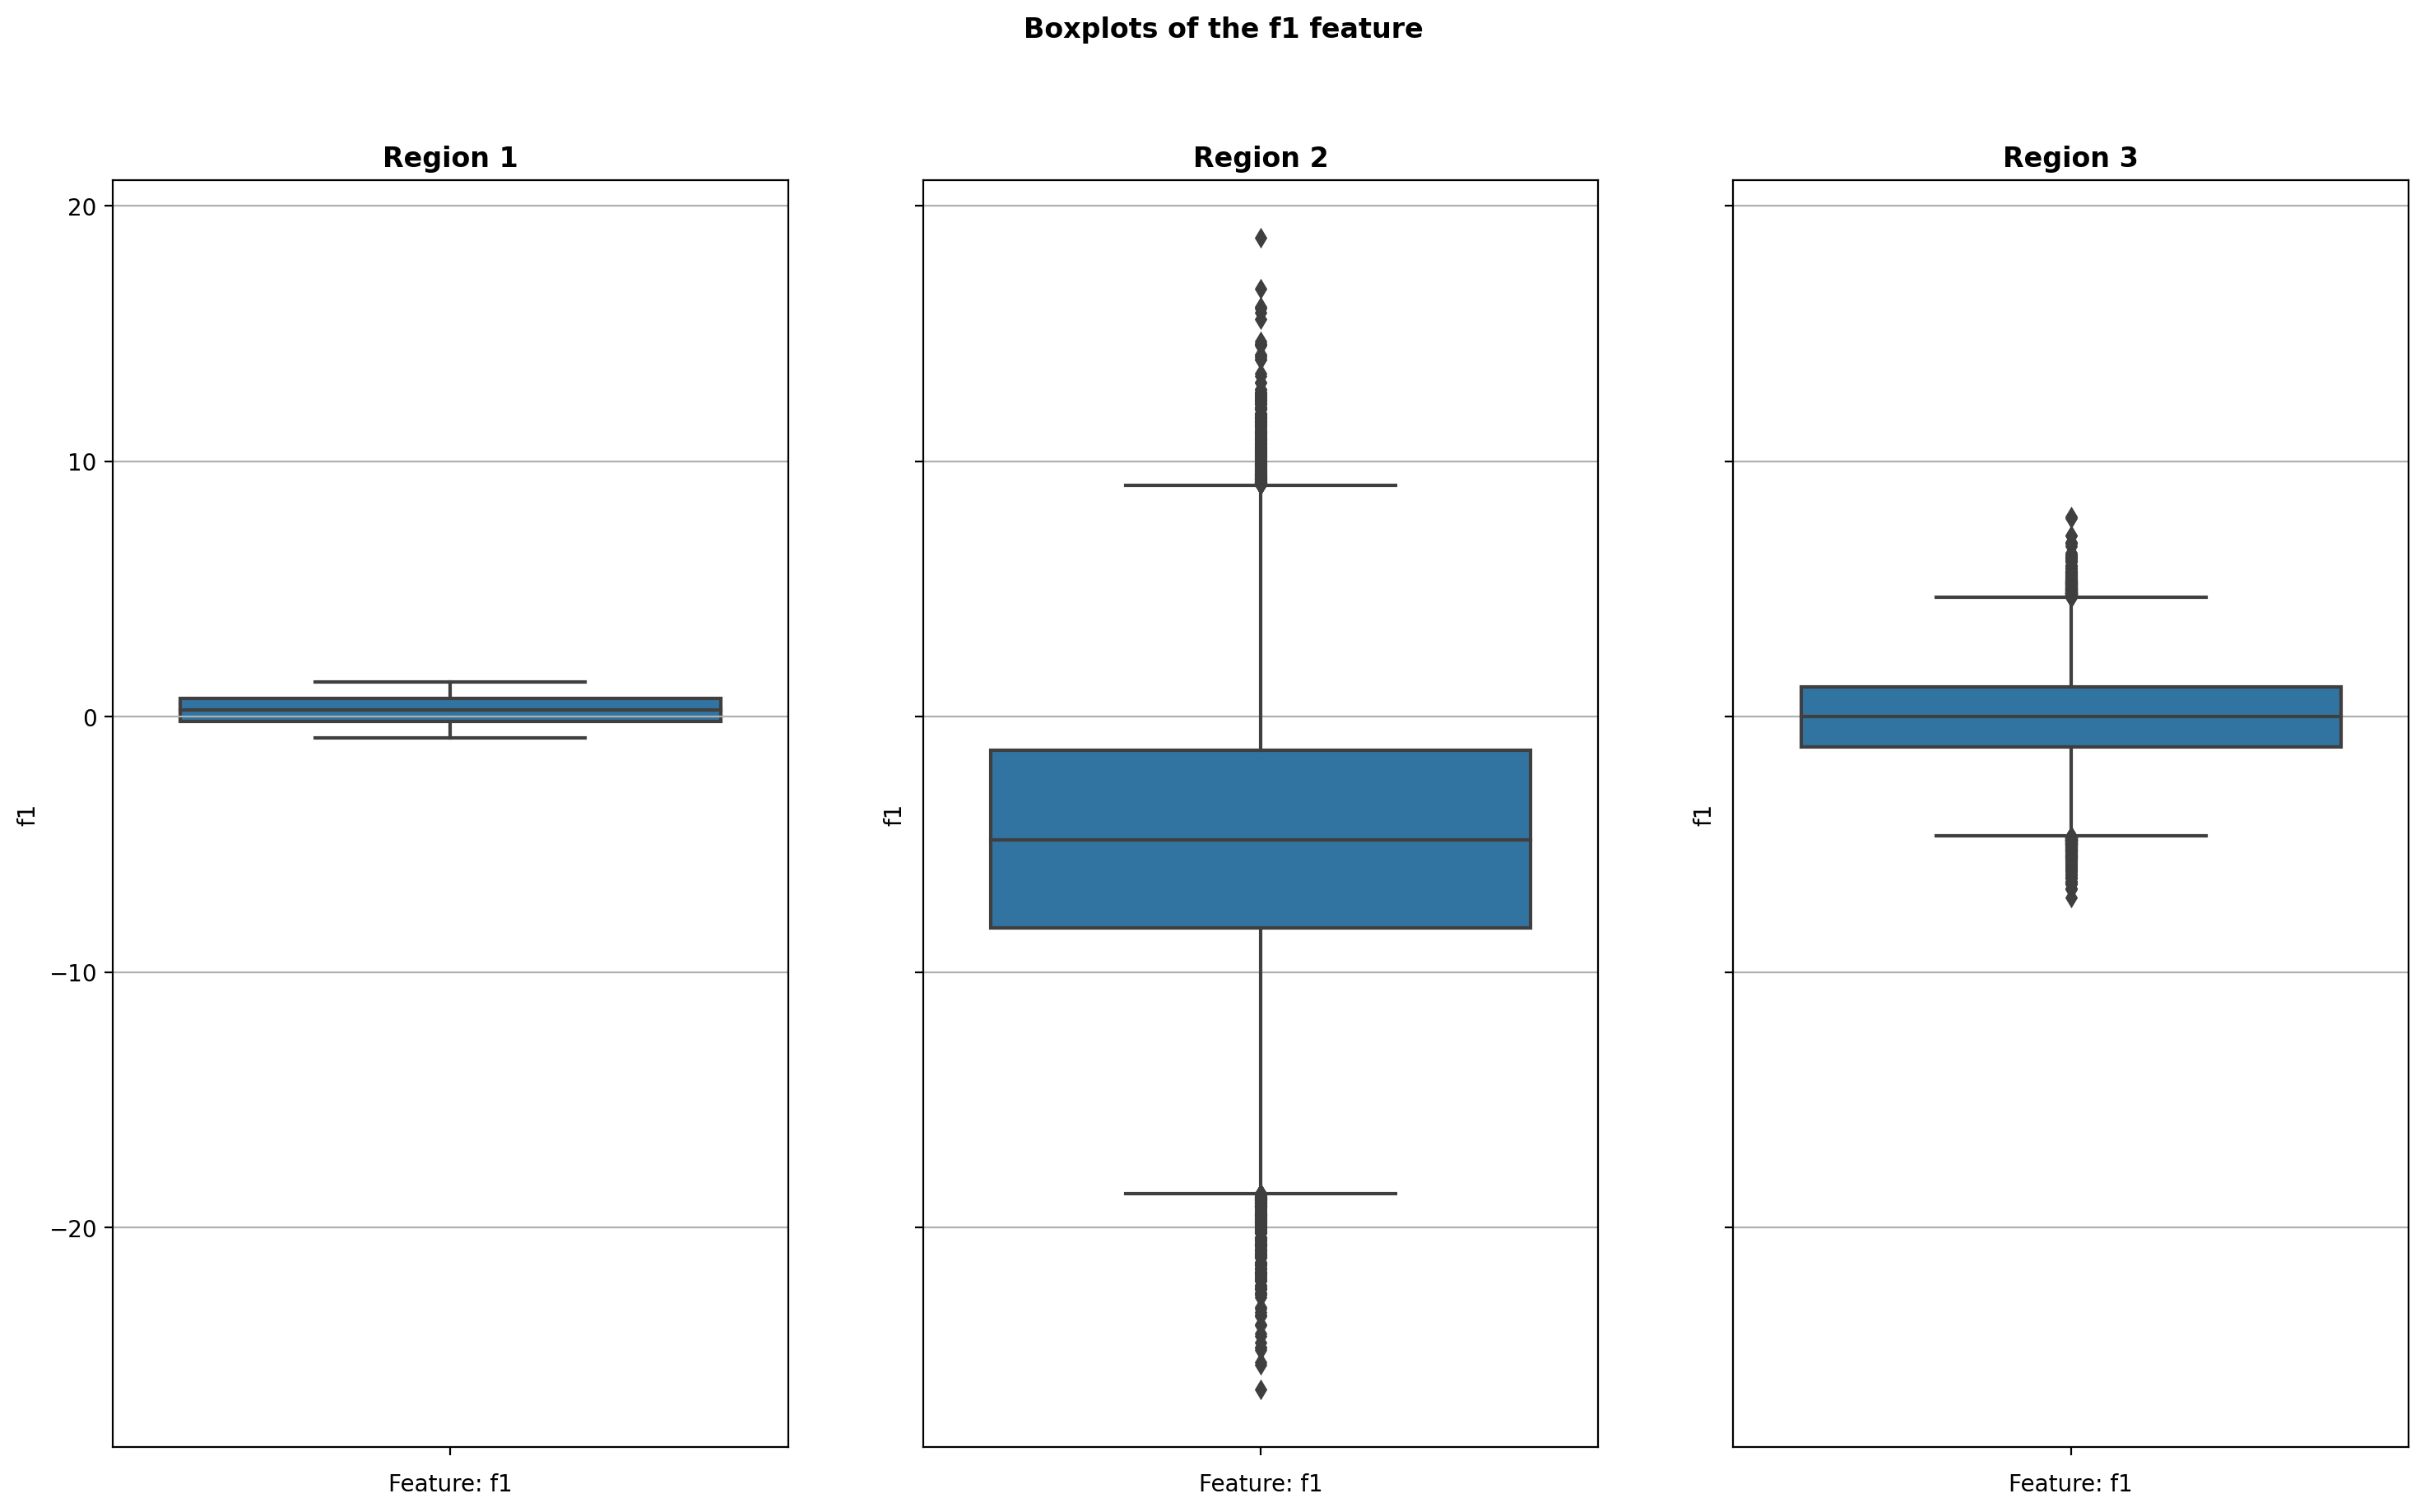

In [24]:
draw_boxplot(data=[data1, data2, data3], column='f1')

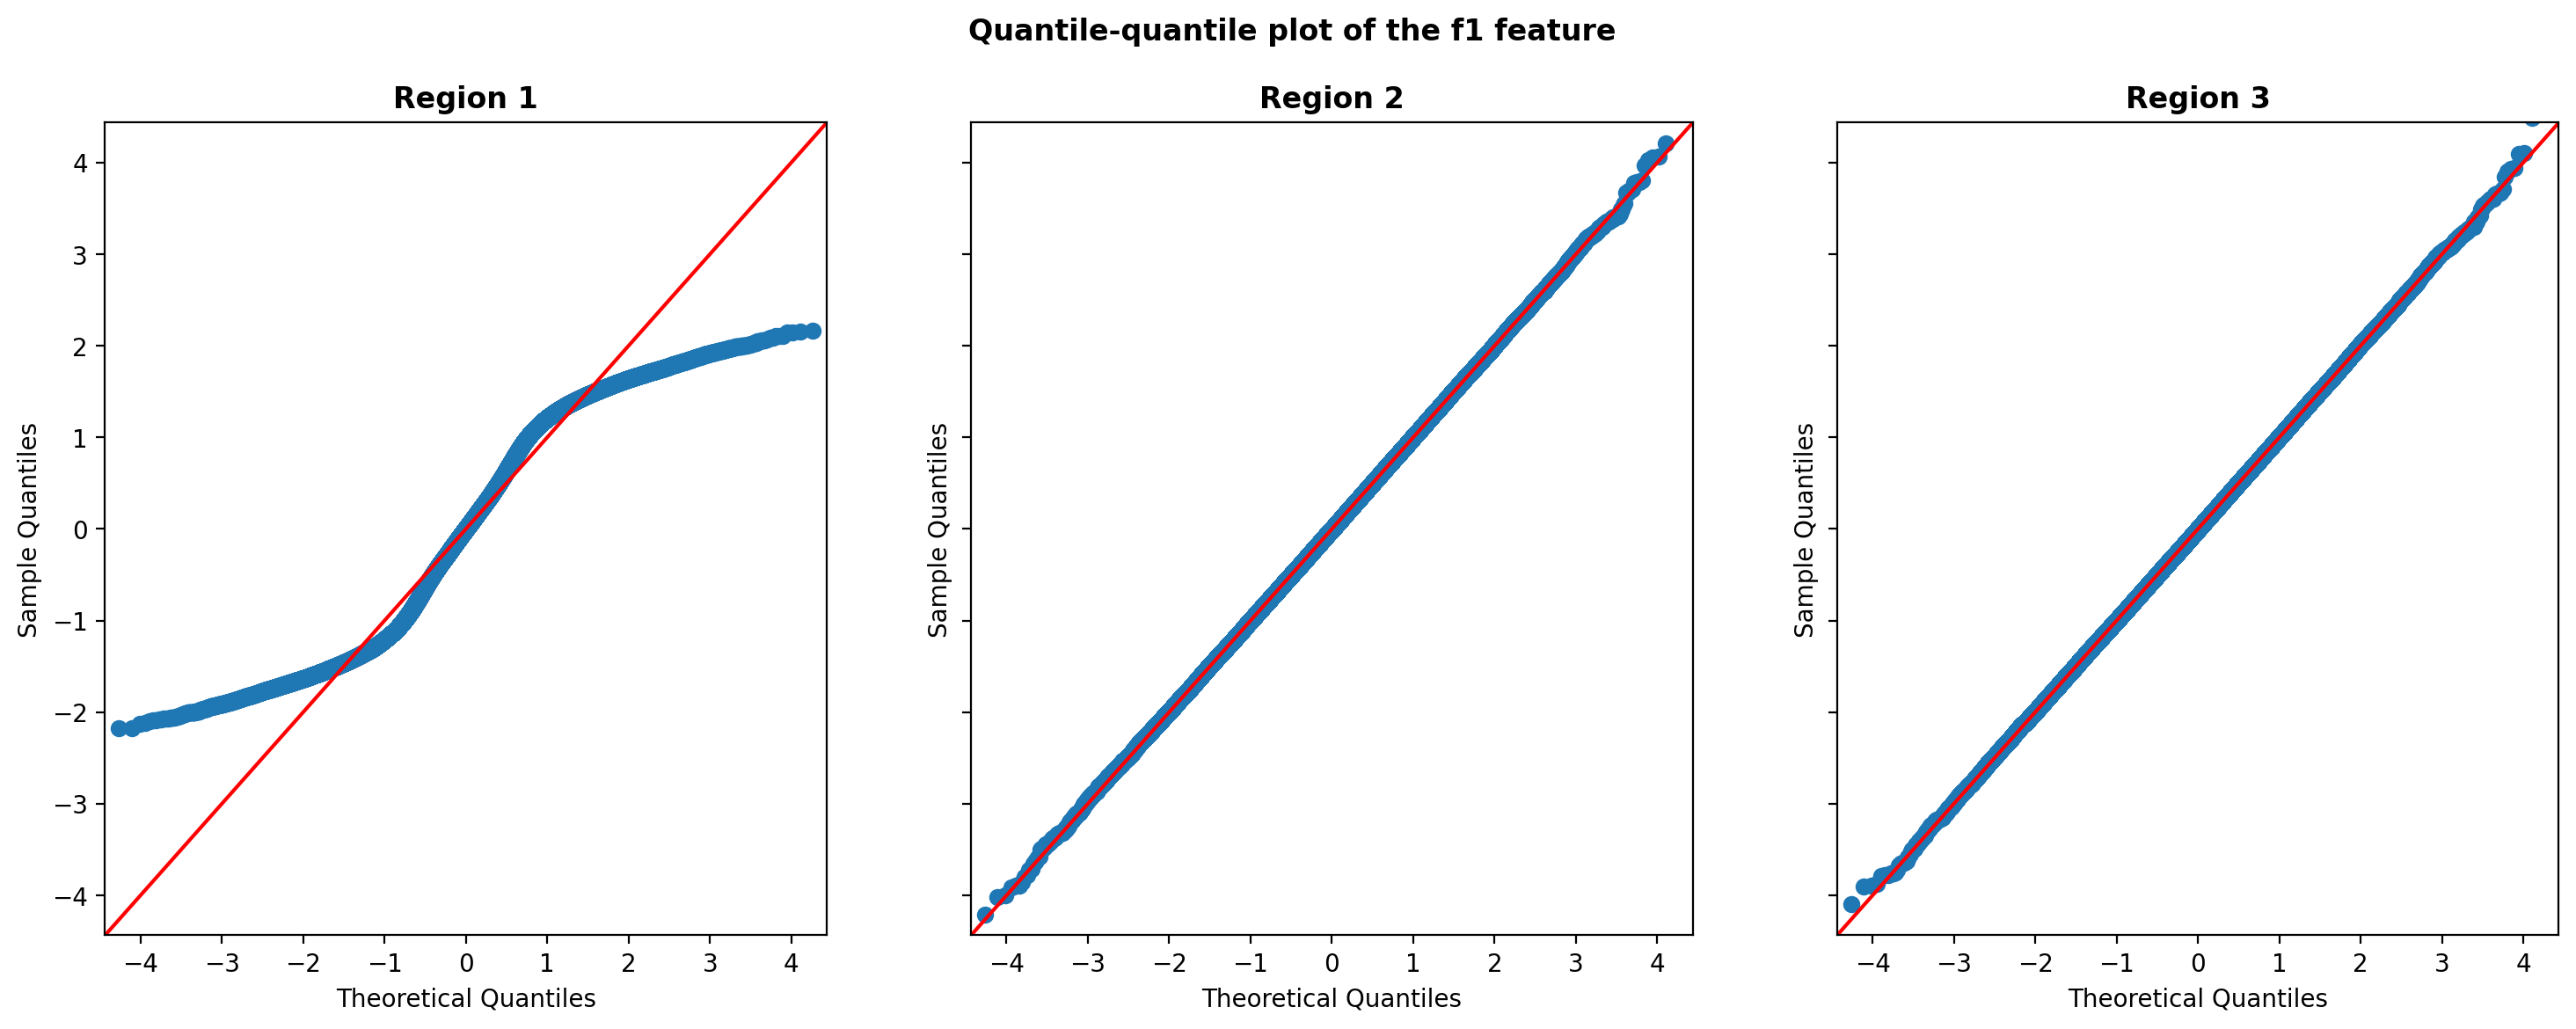

In [25]:
draw_qq_plot(data=[data1, data2, data3], column='f1')

**Observations**:

* The feature `f1` in the first region is not normally distributed and exhibits a multimodal distribution.
* In the second and third regions, the feature `f1` is normally distributed.
* The numerical values of the feature also differ across the regions.
* In the second region, the range of values is much wider than in the first and third regions, and the median value is much lower compared to the other regions.
* Outliers are observed in the first and third regions.

### Feature `f2`

Let's repeat the same actions for the `f2` feature.

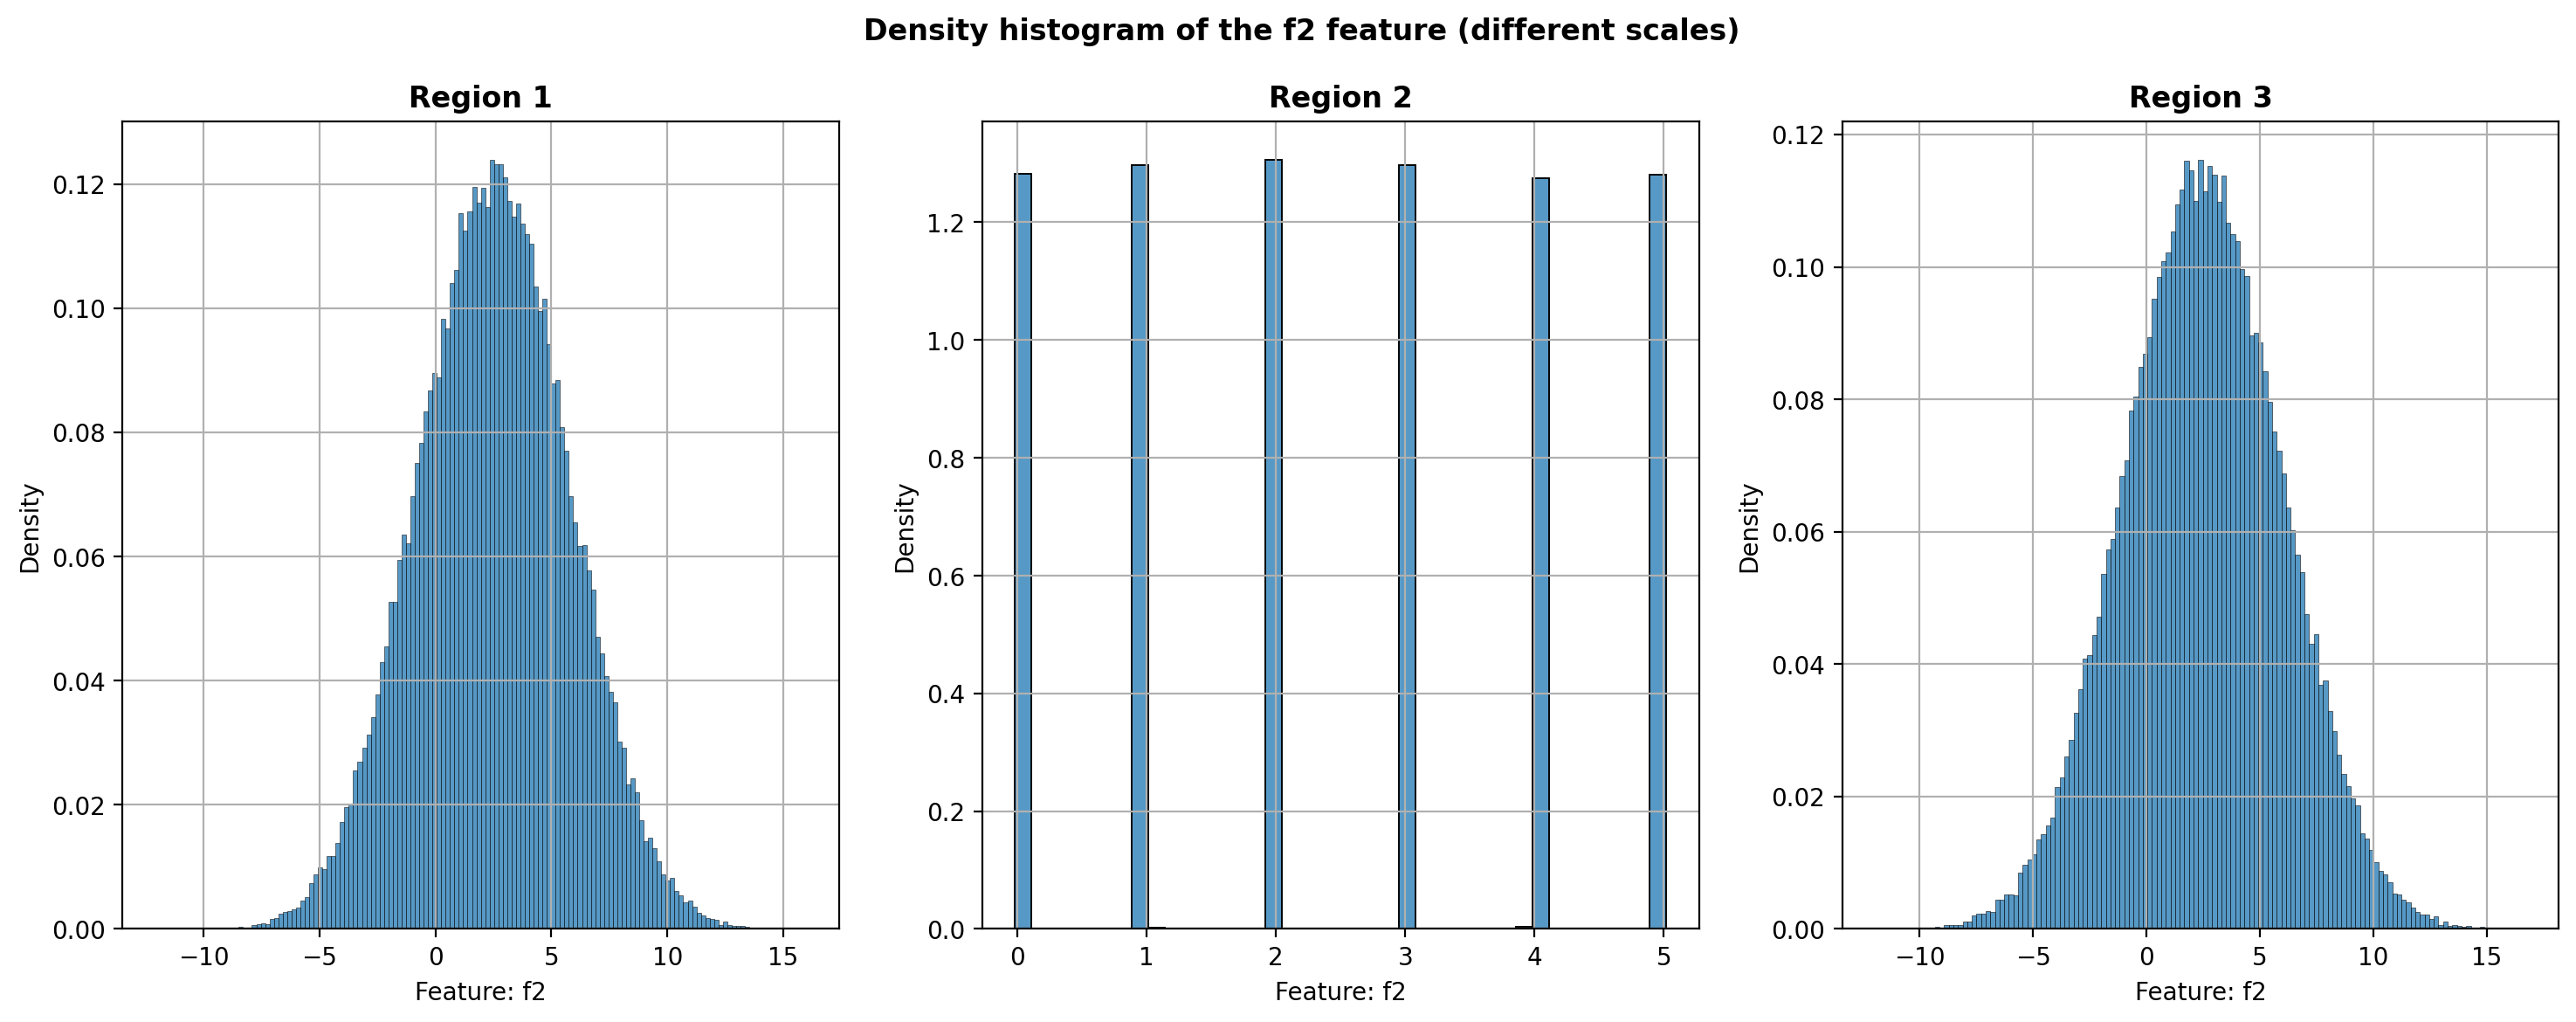

In [26]:
draw_norm_histogram(data=[data1, data2, data3], column='f2')

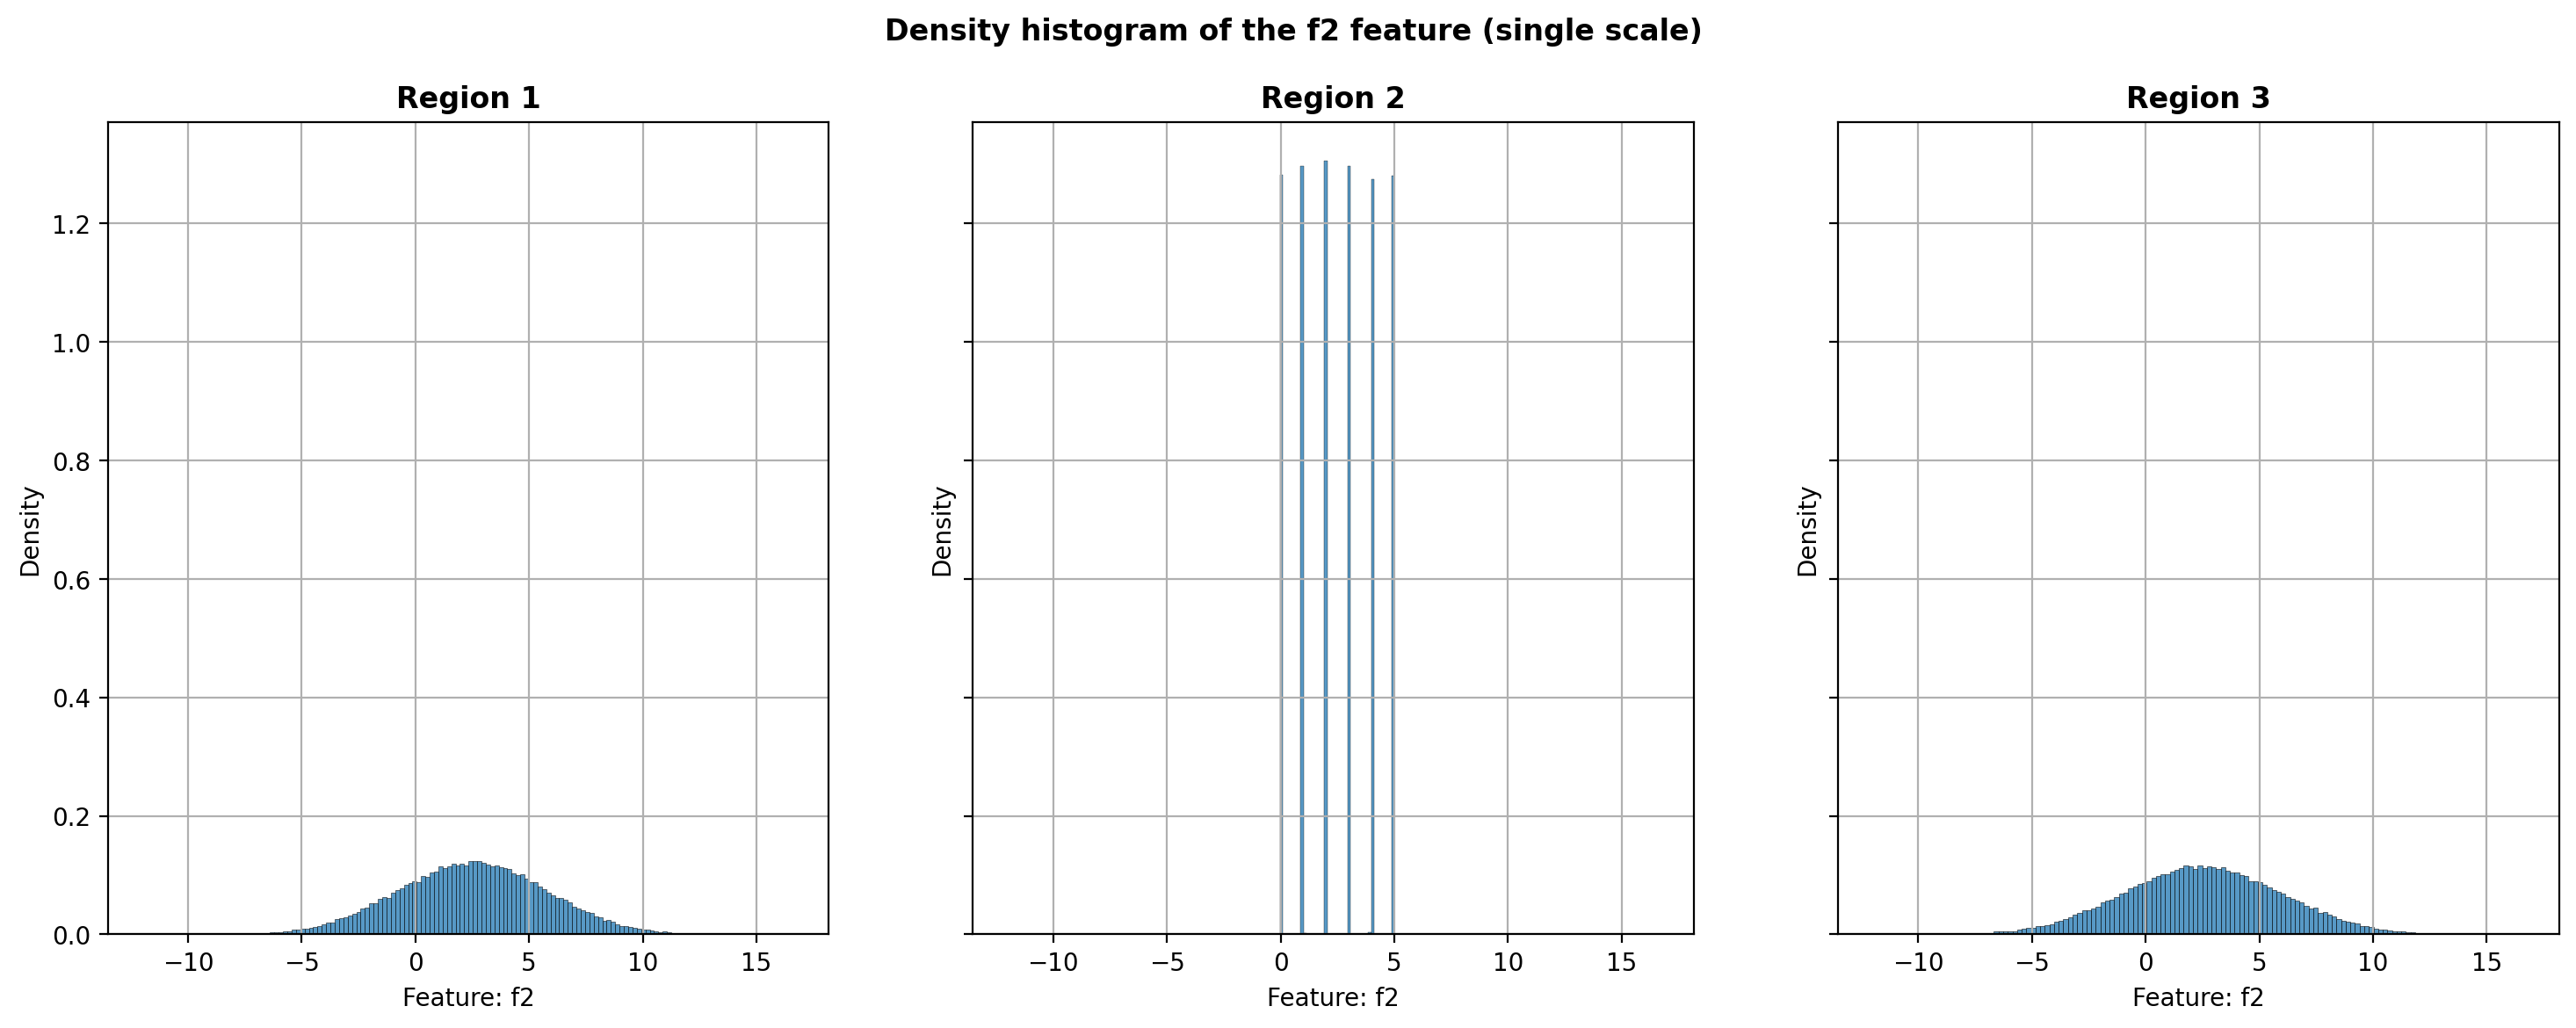

In [27]:
draw_norm_histogram(data=[data1, data2, data3], column='f2', share=True)

In [28]:
show_description(data=[data1, data2, data3], column='f2')

Region 1  Region 2  Region 3
count  99990.00  99996.00  99996.00
mean       2.50      2.49      2.50
std        3.25      1.70      3.47
min      -12.09     -0.02    -11.97
25%        0.29      1.00      0.13
50%        2.52      2.01      2.48
75%        4.71      4.00      4.86
max       16.00      5.02     16.74

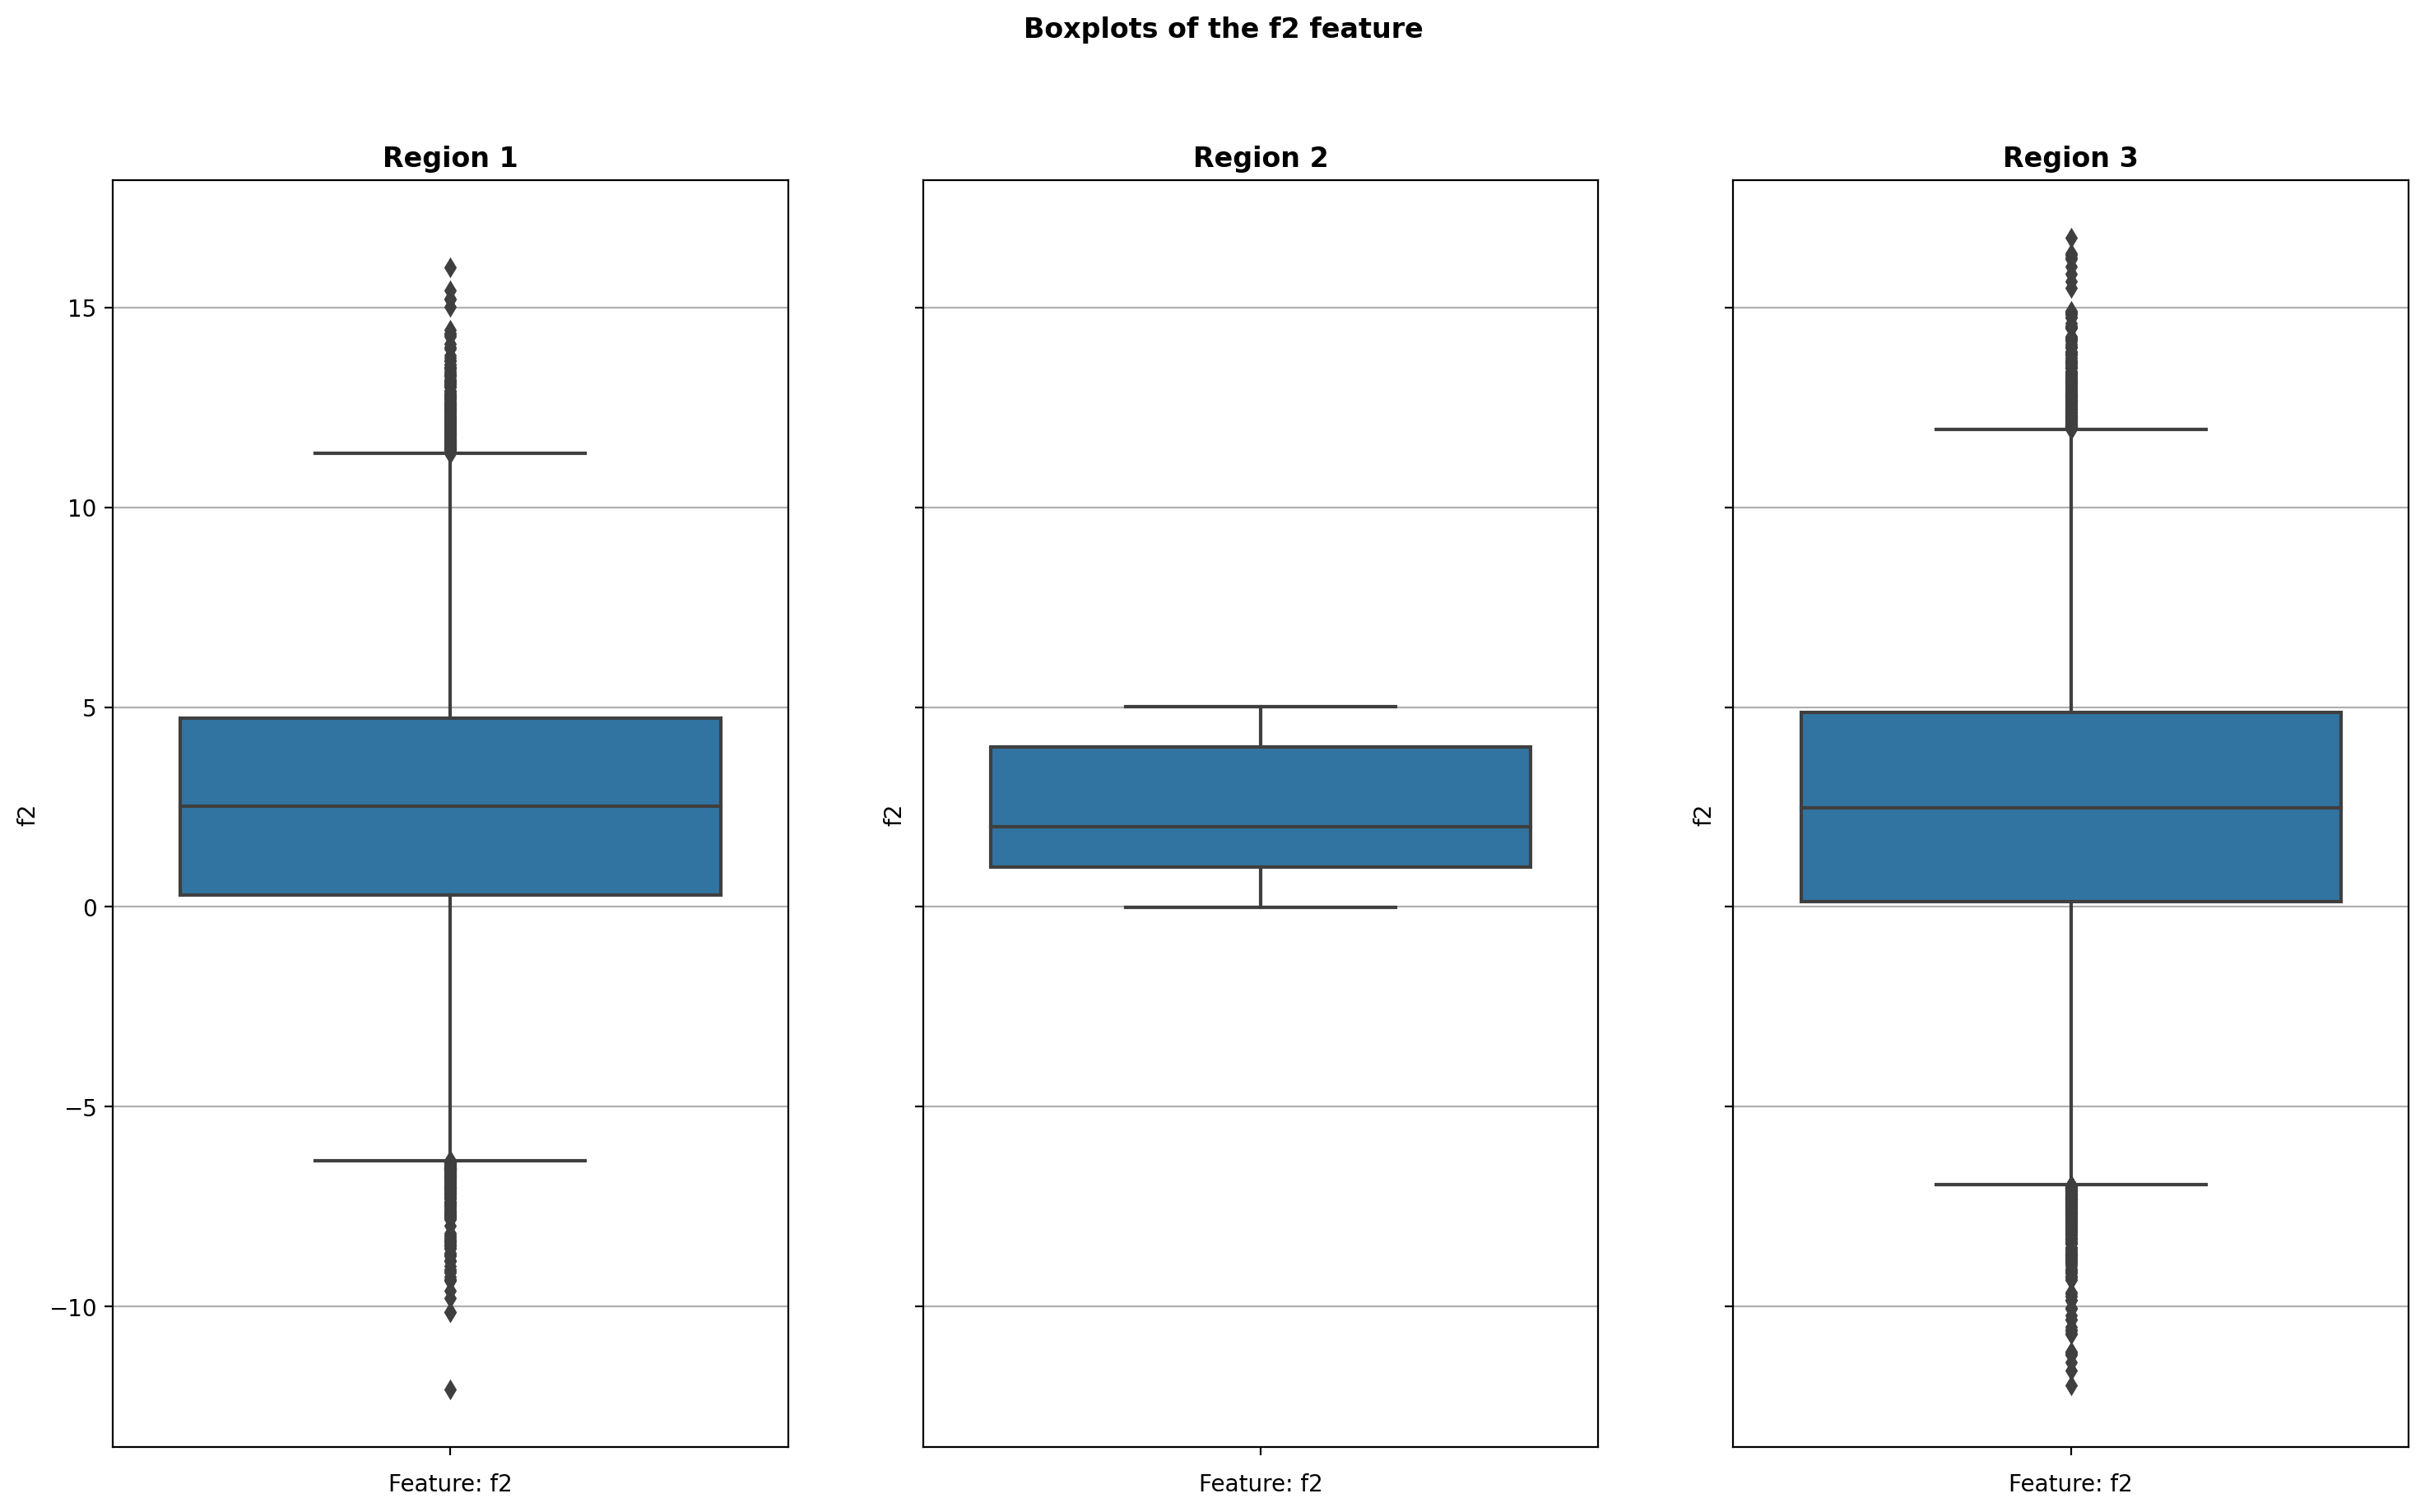

In [29]:
draw_boxplot(data=[data1, data2, data3], column='f2')

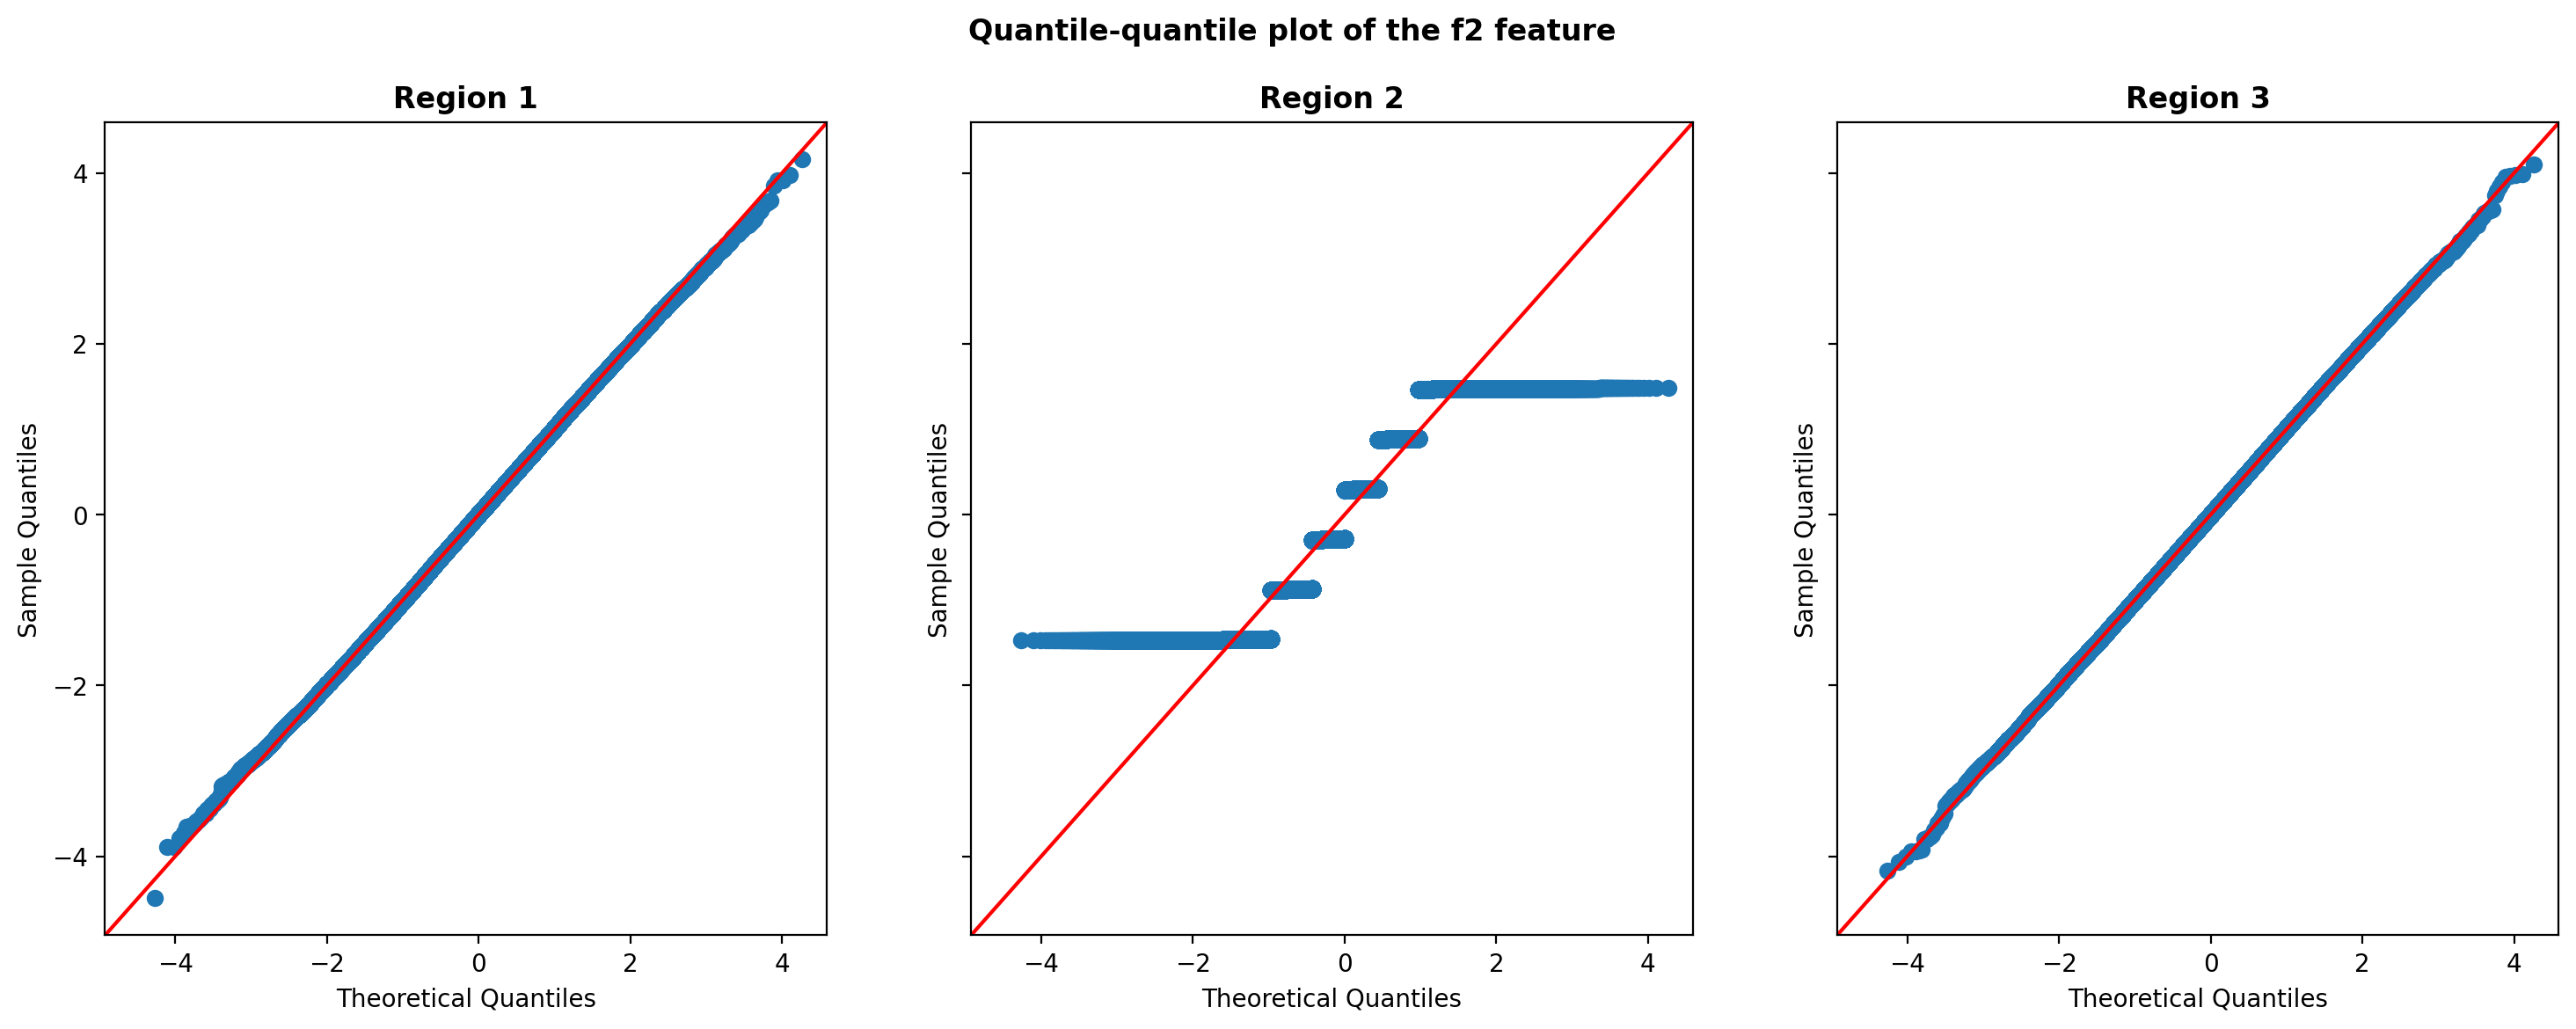

In [30]:
draw_qq_plot(data=[data1, data2, data3], column='f2')

**Observations**:

* The feature `f2` in the second region is not normally distributed and is described by a discrete variable.
* In the first and third regions, the feature `f2` is normally distributed.
* The numerical values of the feature also differ across the regions.
* In the second region, the range of values is much narrower than in the first and third regions.
* Outliers are observed in the first and third regions.

### Target feature `product`

Let's repeat the same actions for the target feature `product`.

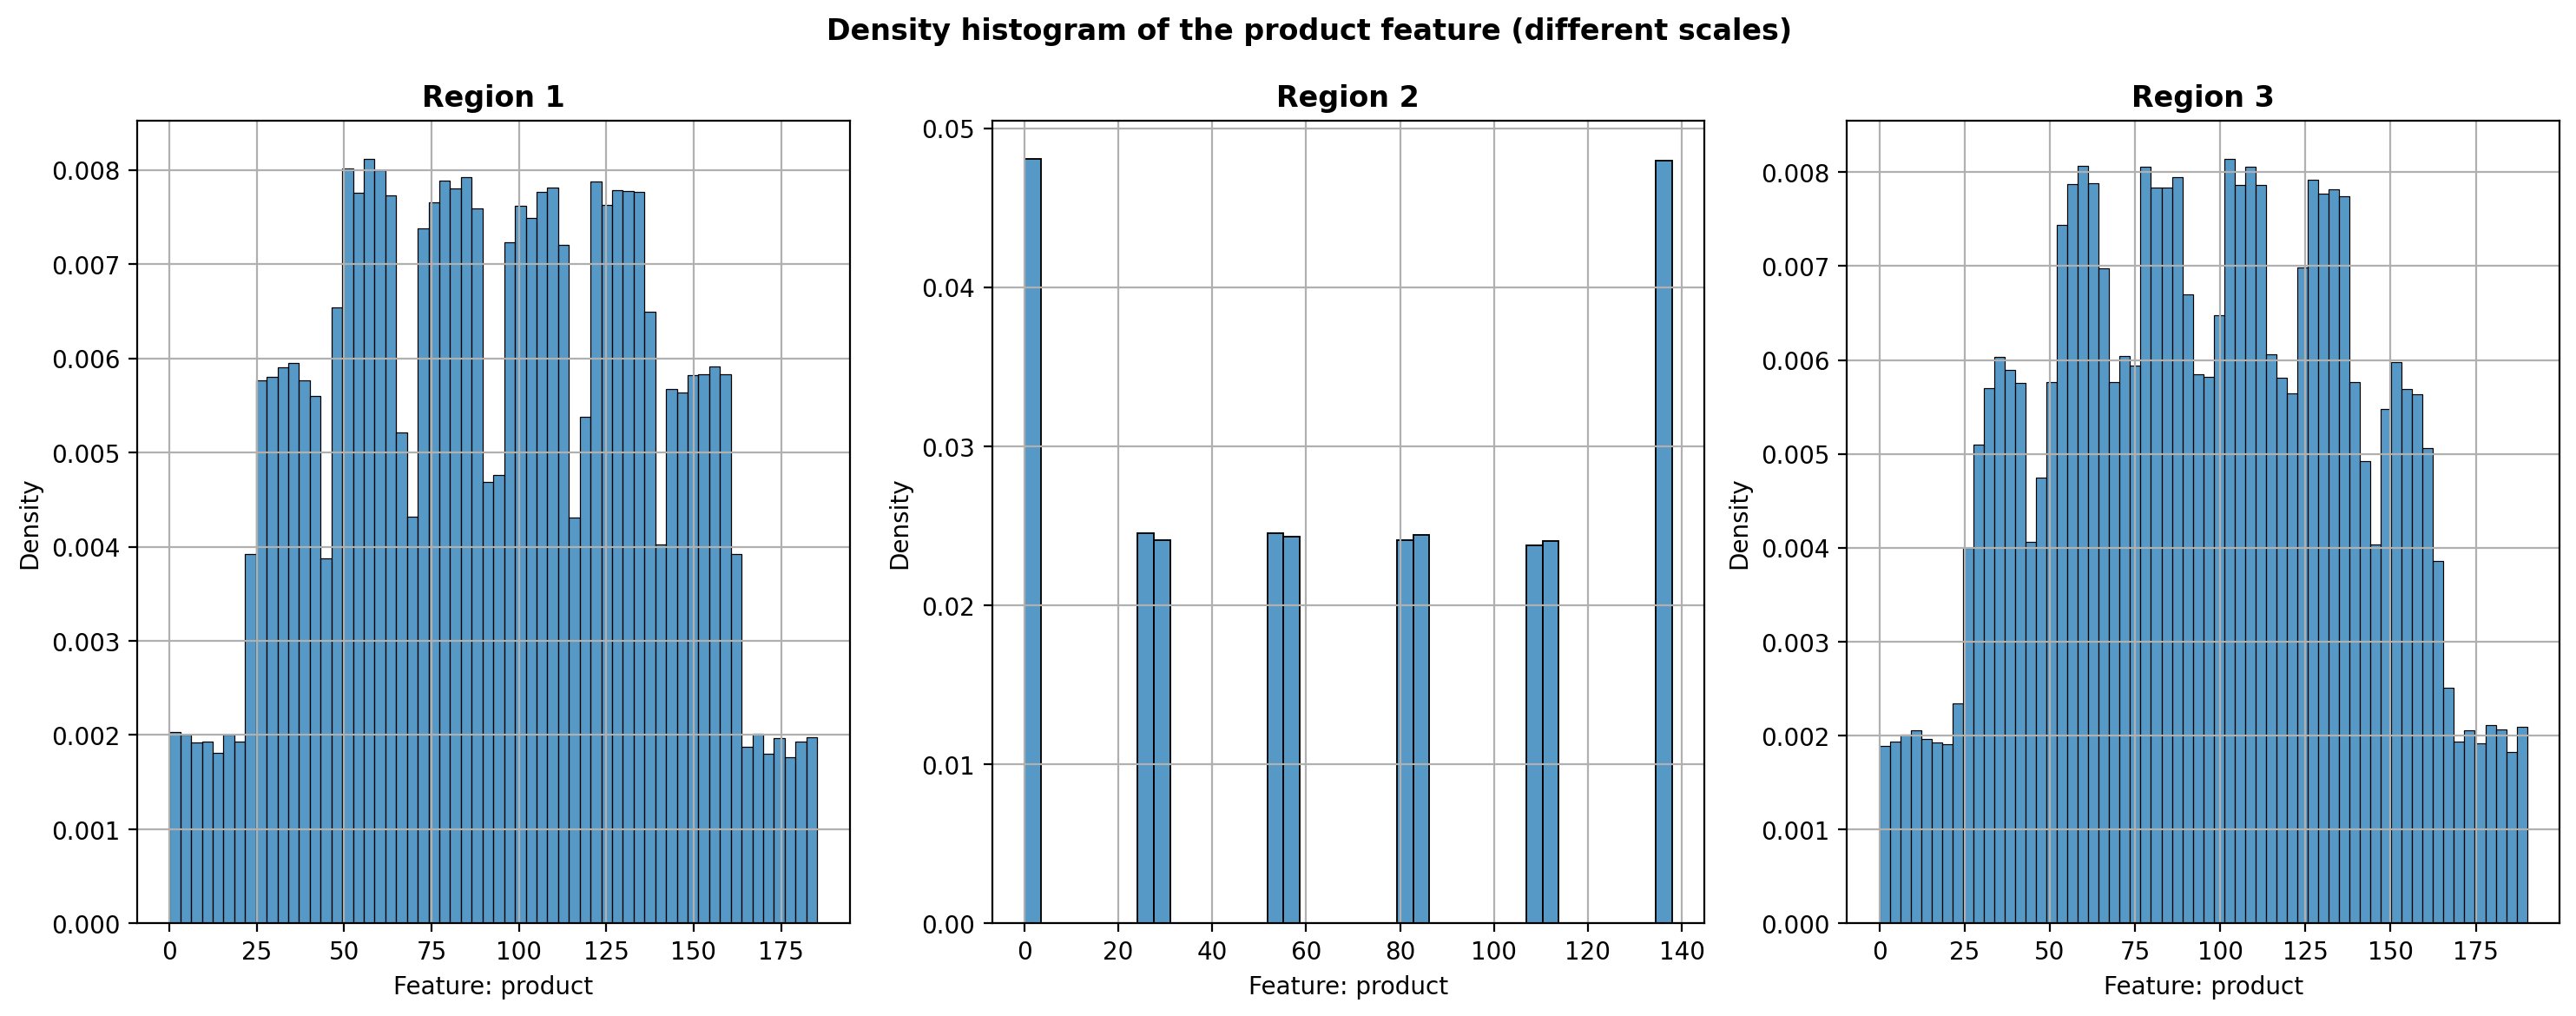

In [31]:
draw_norm_histogram(data=[data1, data2, data3], column='product')

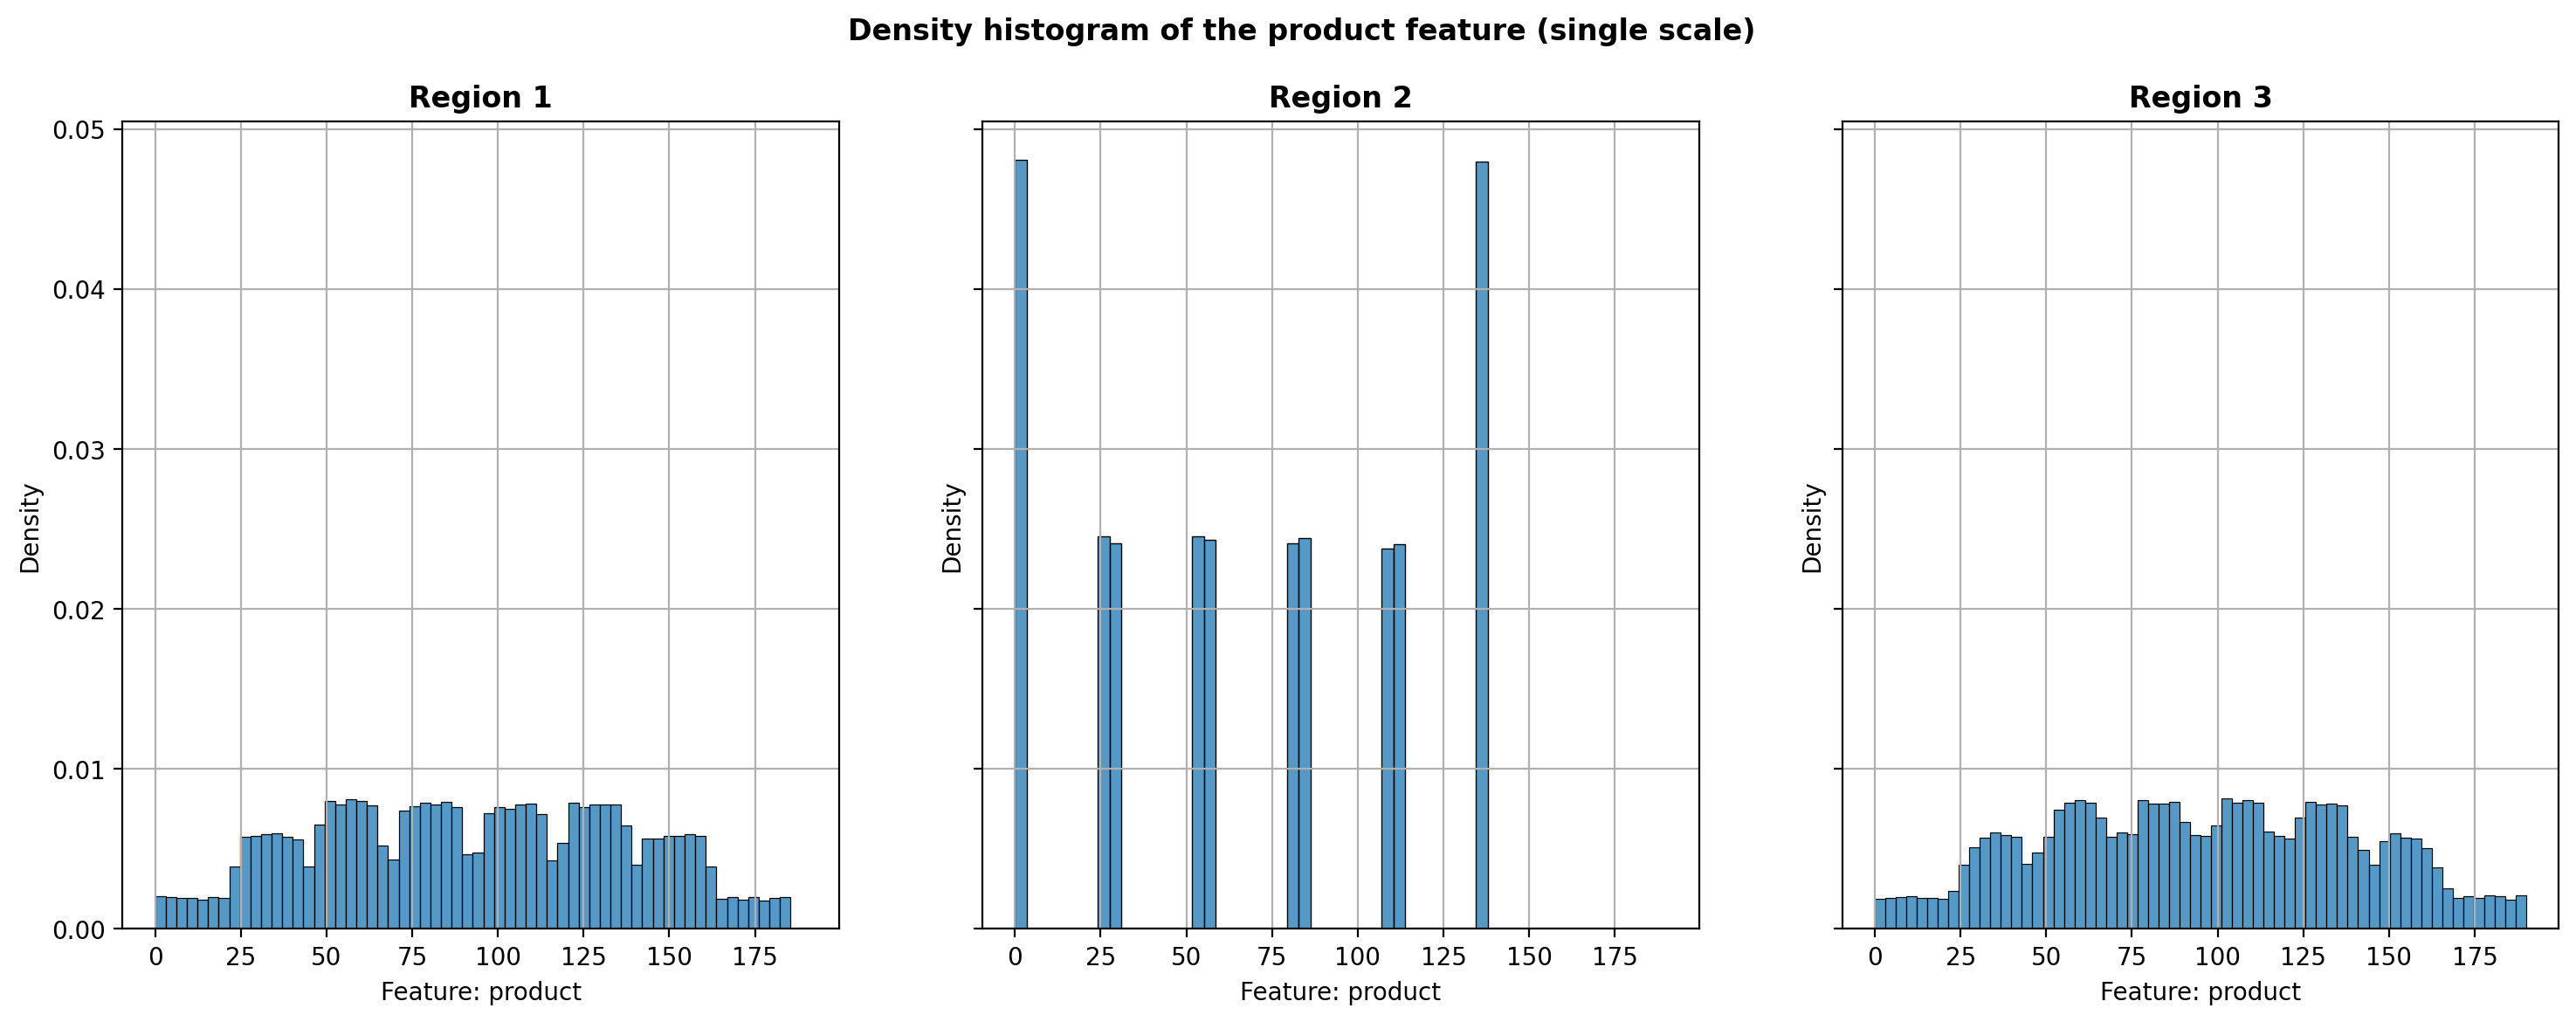

In [32]:
draw_norm_histogram(data=[data1, data2, data3], column='product', share=True)

In [33]:
show_description(data=[data1, data2, data3], column='product')

Region 1  Region 2  Region 3
count  99990.00  99996.00  99996.00
mean      92.50     68.83     95.00
std       44.29     45.94     44.75
min        0.00      0.00      0.00
25%       56.50     26.95     59.45
50%       91.85     57.09     94.93
75%      128.56    107.81    130.59
max      185.36    137.95    190.03

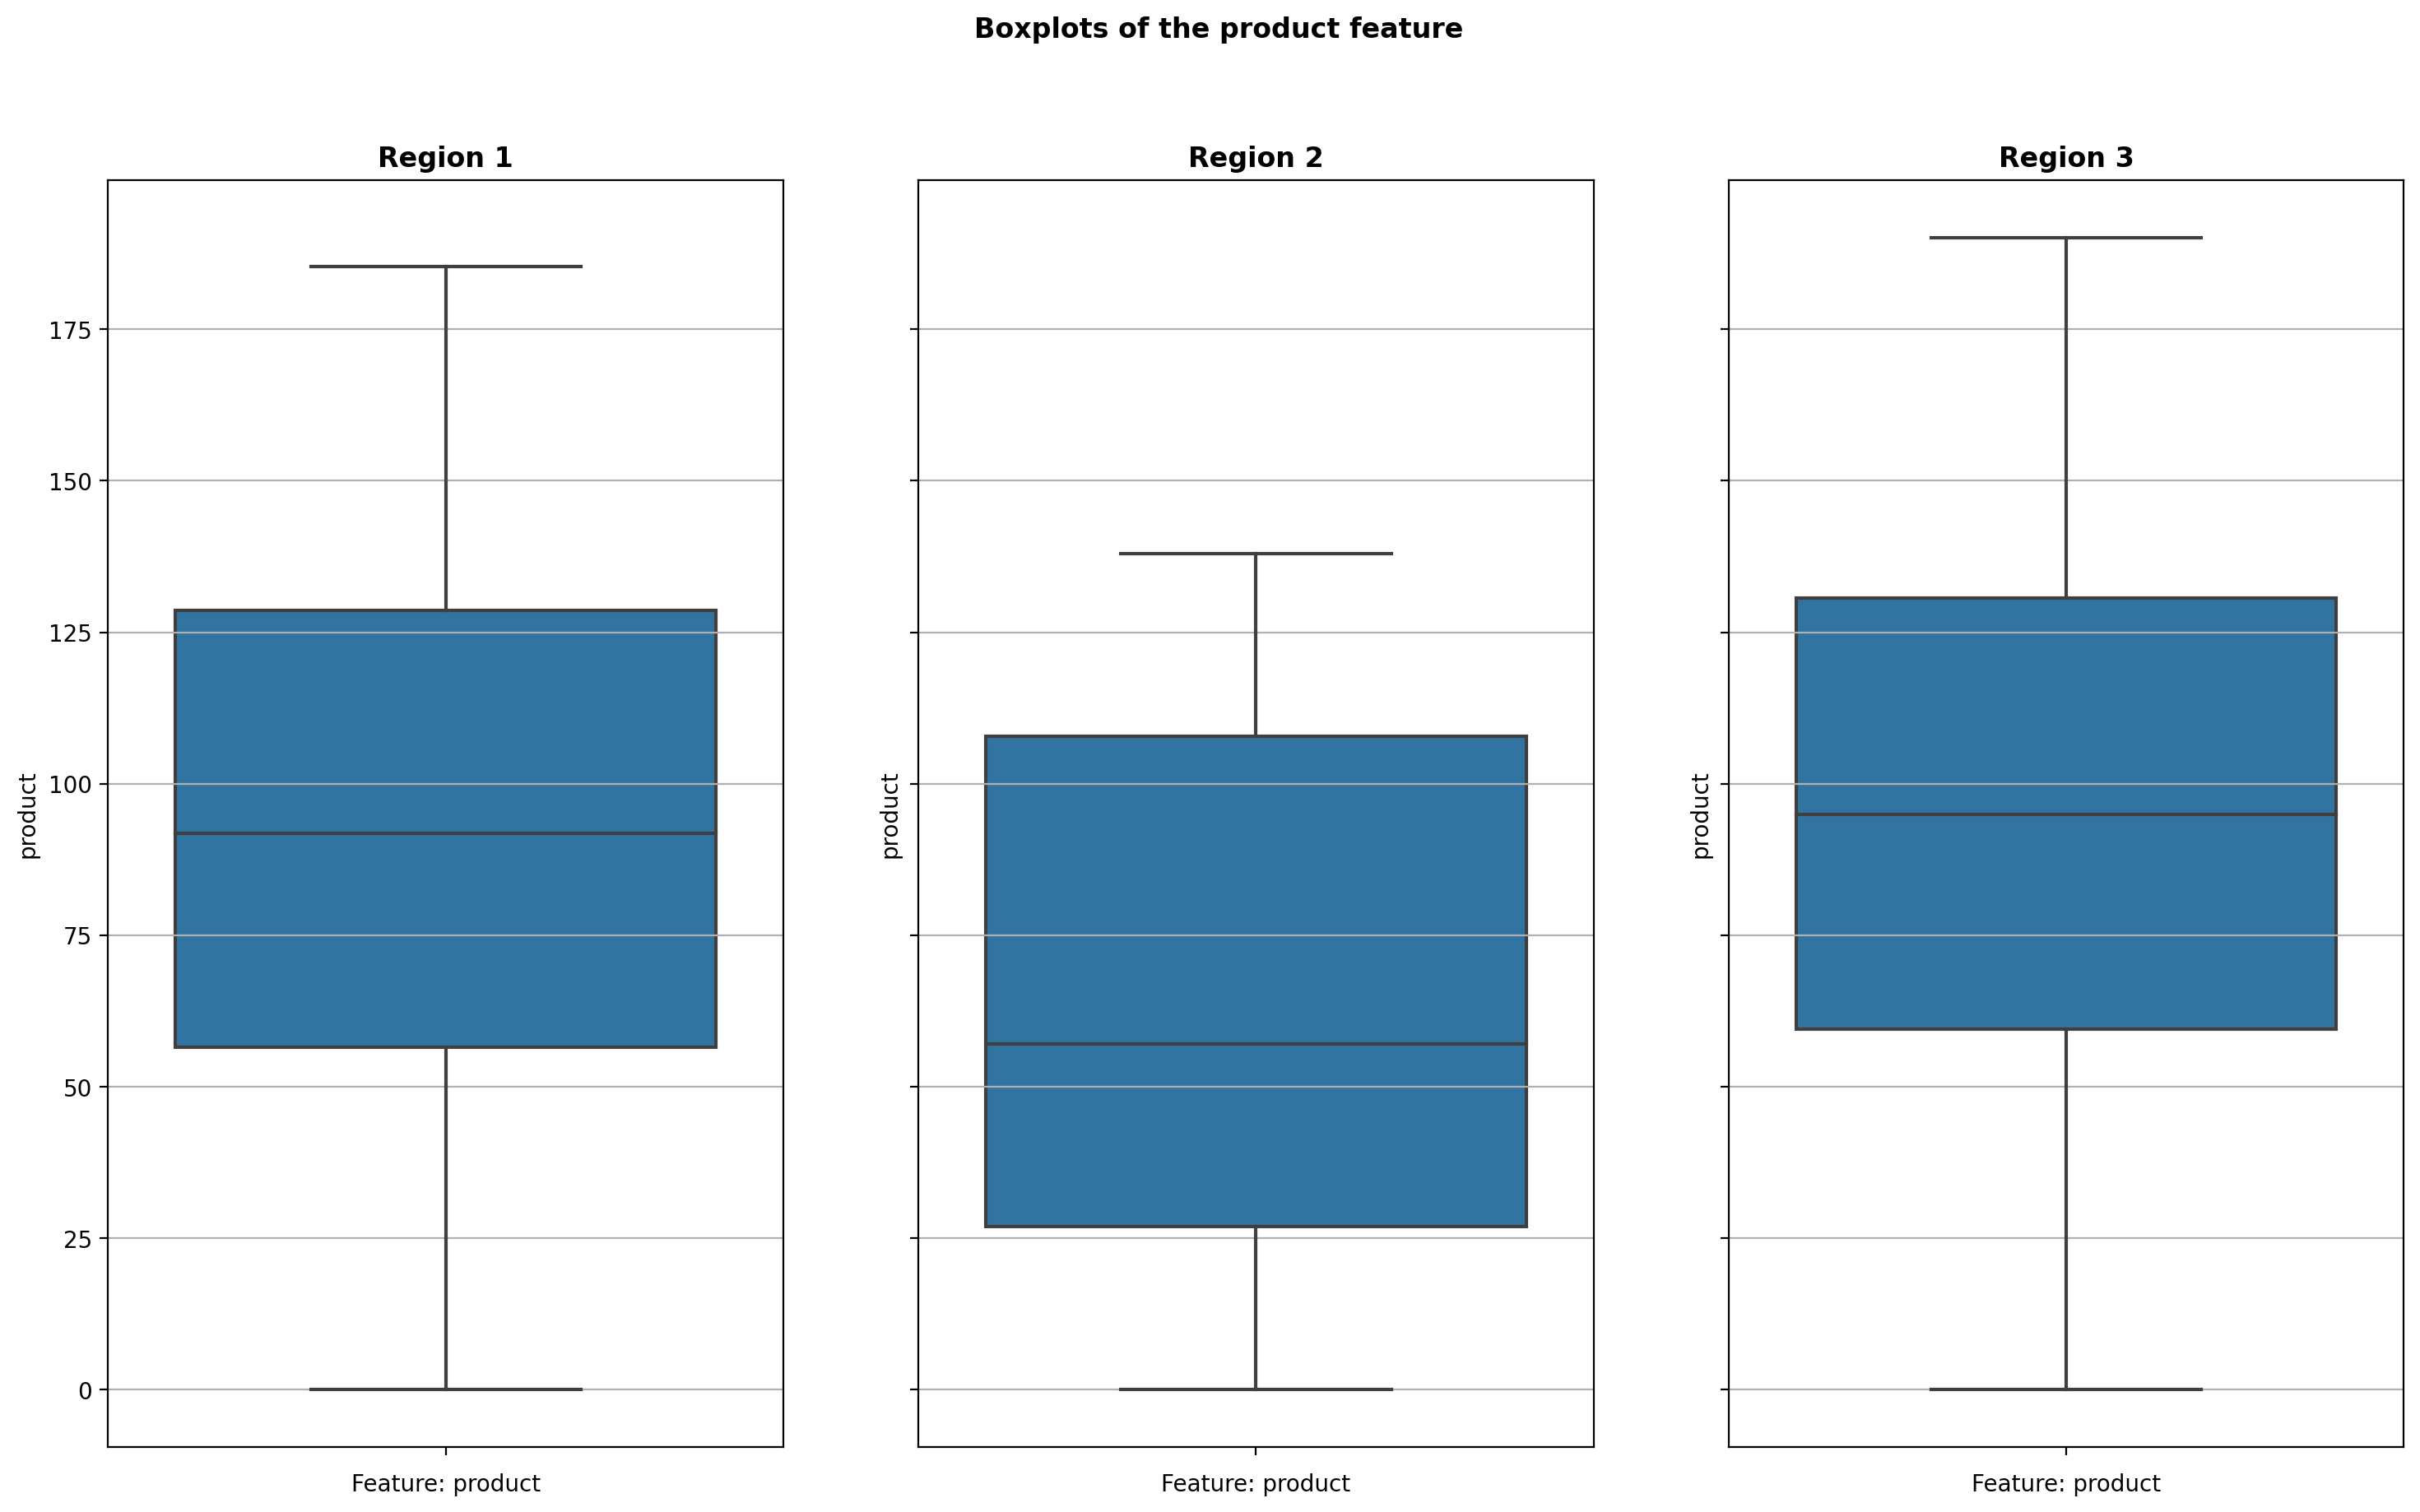

In [34]:
draw_boxplot(data=[data1, data2, data3], column='product')

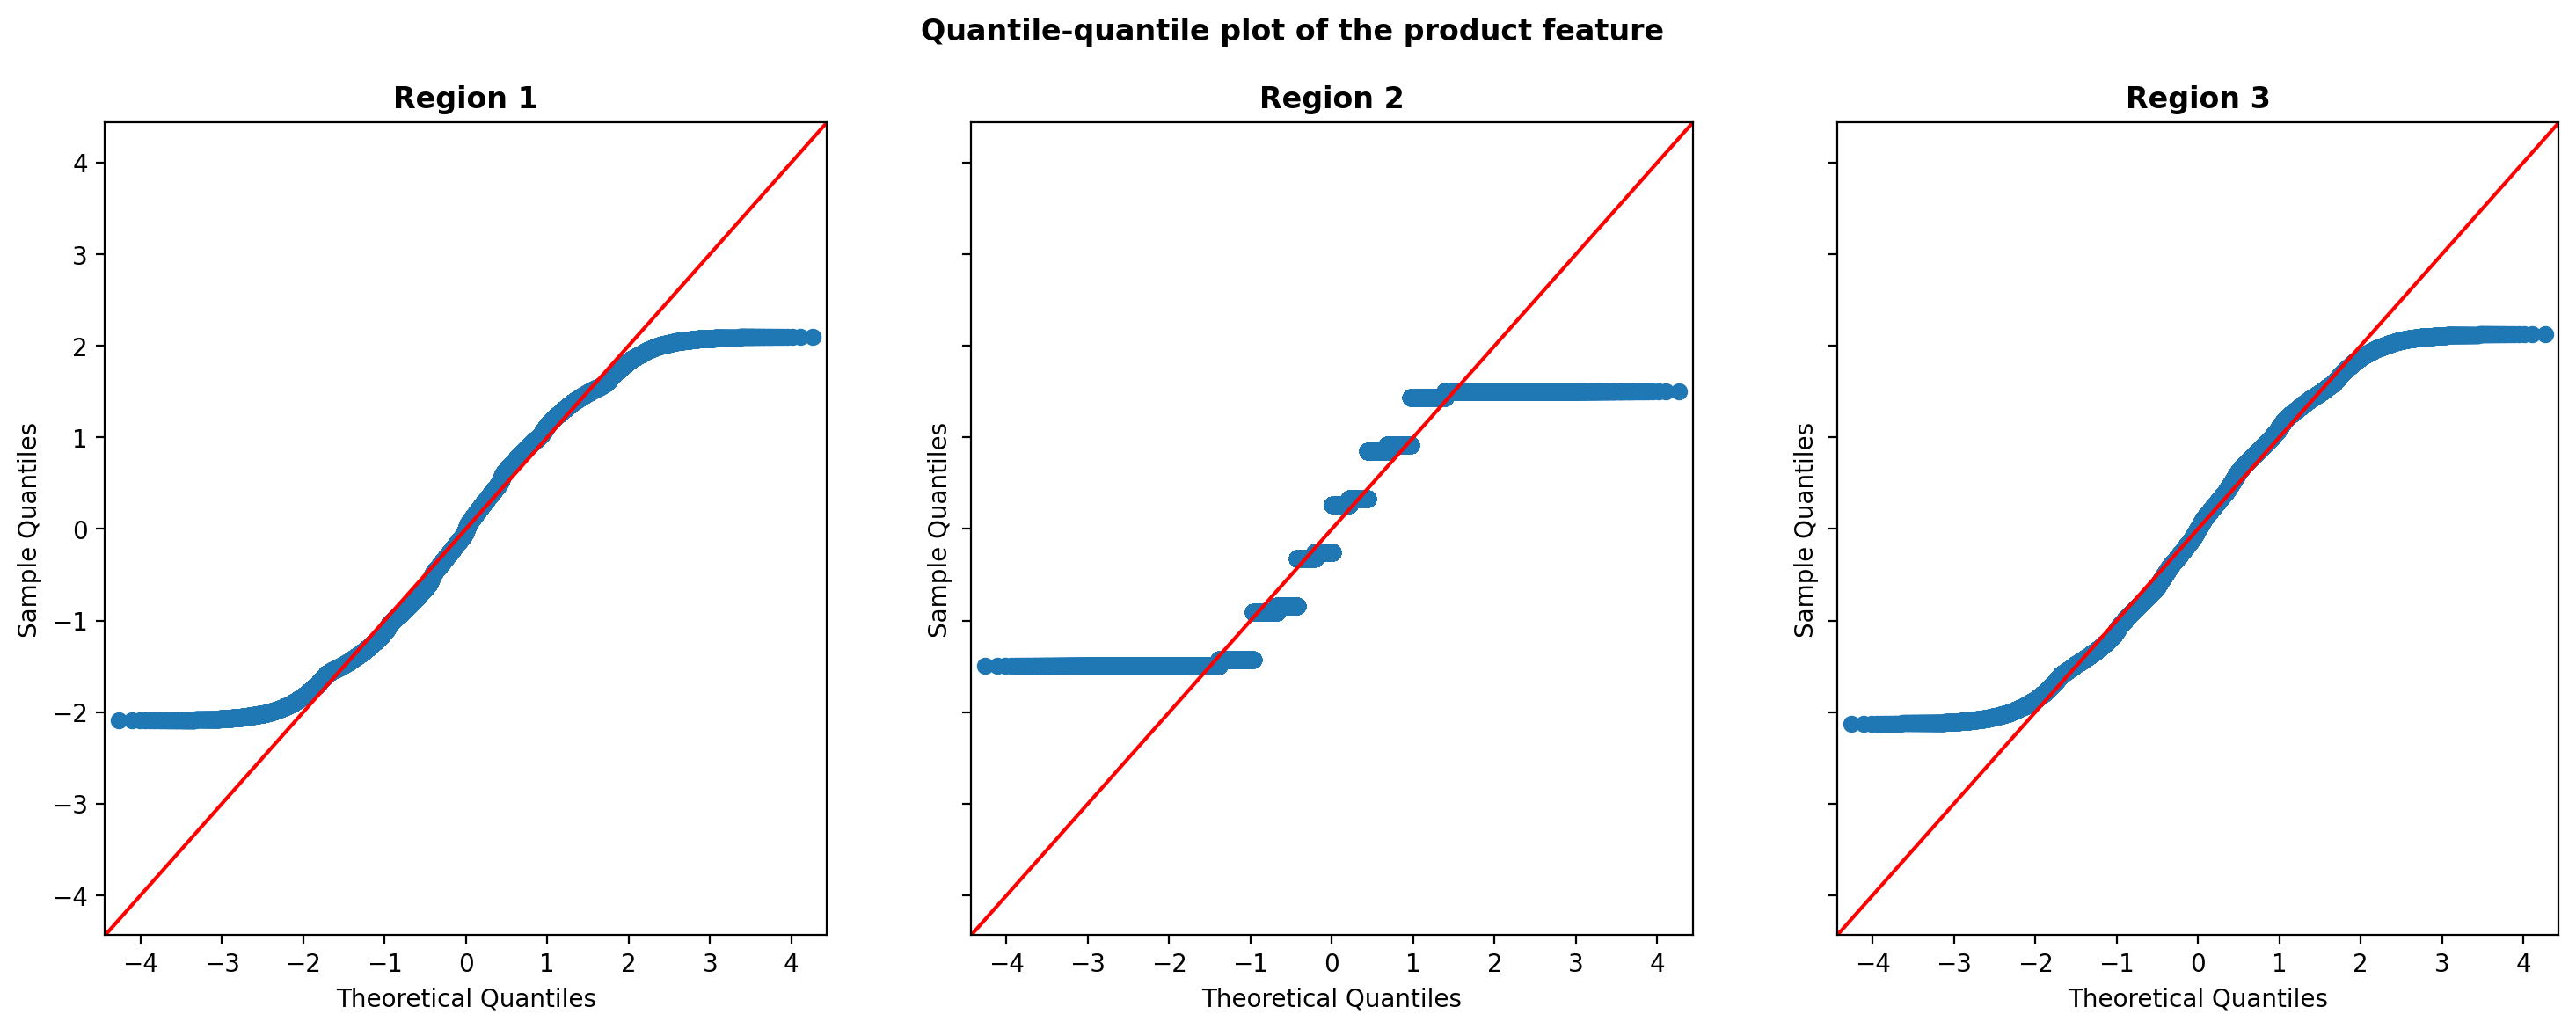

In [35]:
draw_qq_plot(data=[data1, data2, data3], column='product')

**Observations**:

* The target feature `product` in all three regions is not normally distributed.
* In the first and third regions, it has a multimodal distribution, while in the second region, it is described by a discrete variable.
* The numerical values of the feature also vary across the regions.
* In the second region, the median value of the feature is significantly lower than in the first and third regions.
* No outliers are observed in any of the three regions.

### Correlation analysis

Since the datasets contain features with non-normally distributed data, we will use Spearman's rank correlation.

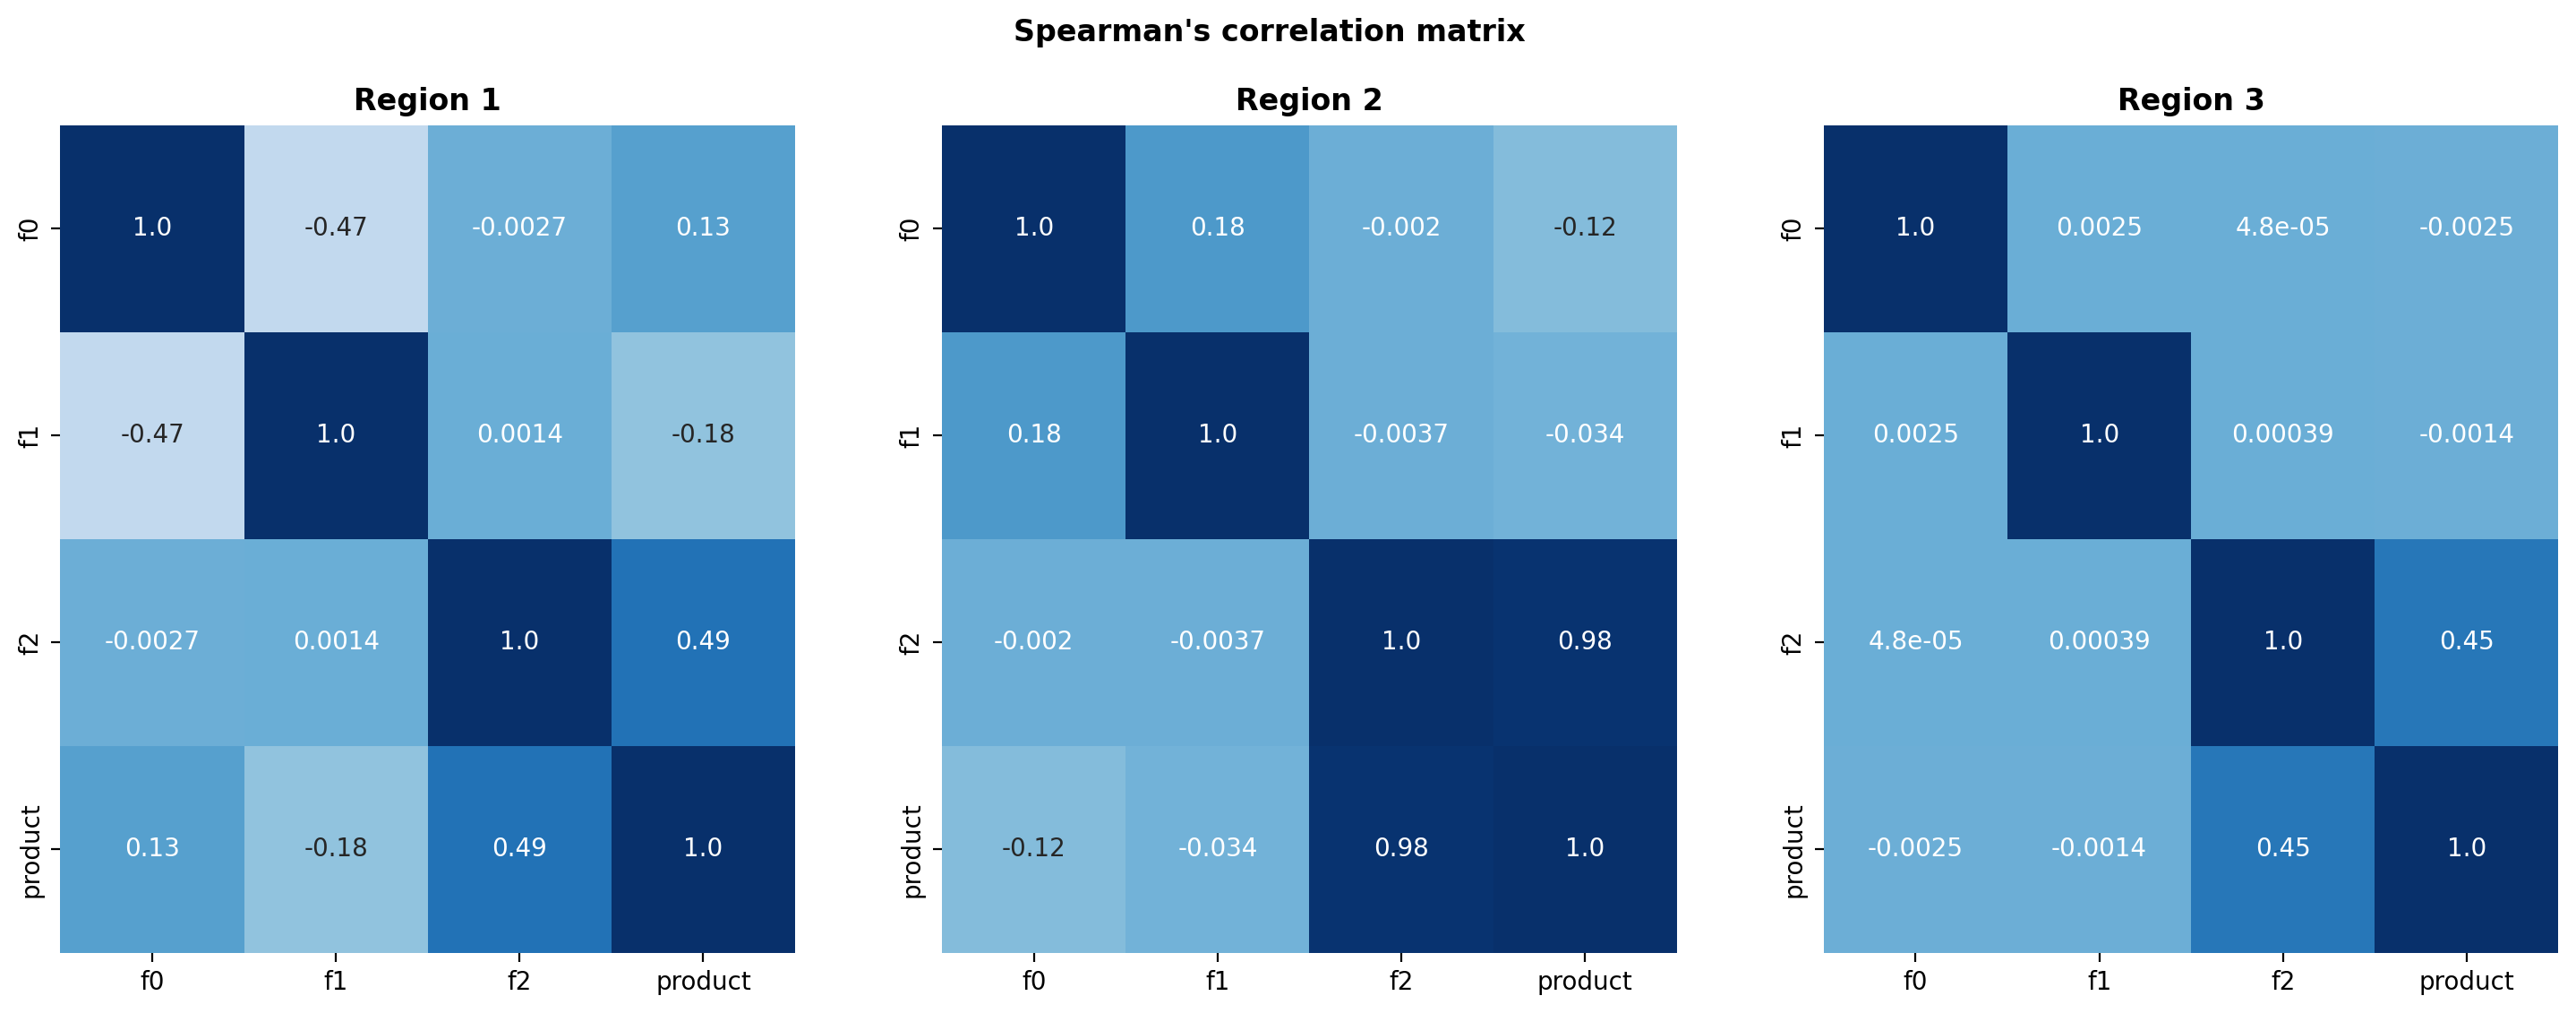

In [36]:
draw_corr_matrix(data=[data1, data2, data3])

**Observations:**

* No multicollinearity observed among the input features.
* In the second region, there is almost complete correlation between the target feature and the `f2` feature.
* In the first and third regions, there is no strong linear relationship between the target and input features. This means that the quality of models for the first and third regions may be suboptimal, while the model quality for the second region will be very high.

## 4. Machine learning model for crude oil reserve prediction

The problem at hand is regression, as we need to obtain precise values for a quantitative feature. To address this regression task, we will employ a linear regression model, as it is the customer's requirement.

To start with, we will create variables to store metrics and values necessary for profit calculation. Additionally, we will create a function that can be applied in each region to train the models.

In [37]:
# Variables for quality metrics
metrics_rmse_train = []
metrics_r2_train = []
metrics_rmse_test = []
metrics_r2_test = []
mean_crude_oil_true = []
mean_crude_oil_pred = []
bootstrap_data = []

# Function for building a linear regression model
def linear_regression_model(data):
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['product'], axis=1),
    data['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)
    print('Number of rows in training set:', X_train.shape[0])
    print('Number of rows in testing set:', X_test.shape[0], '\n')
        
    # Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Model initialization
    model = LinearRegression()
    
    # Cross-validation
    rmse_train = abs(cross_val_score(model,
                                     X_train,
                                     y_train,
                                     cv=5,
                                     scoring='neg_root_mean_squared_error').mean()).round(2)
    r2_train = cross_val_score(model,
                               X_train,
                               y_train,
                               cv=5,
                               scoring='r2').mean().round(2)
    
    # Model training
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Quality metrics on the test set
    rmse_test = round(root_mean_squared_error(y_test, y_pred), 2)
    r2_test = round(r2_score(y_test, y_pred), 2)
    mean_oil_true = round(y_test.mean(), 2)
    mean_oil_pred = round(y_pred.mean(), 2)
    
    print('RMSE (cross-validation) = ', rmse_train)
    print('R2 (cross-validation) = ', r2_train, '\n')
    
    print('RMSE (test) = ', rmse_test)
    print('R2 (test) = ', r2_test, '\n')
    
    print('Mean crude oil (real)', mean_oil_true)
    print('Mean crude oil (predicted)', mean_oil_pred)
    
    # Save the metrics
    metrics_rmse_train.append(rmse_train)
    metrics_r2_train.append(r2_train)
    metrics_rmse_test.append(rmse_test)
    metrics_r2_test.append(r2_test)
    
    mean_crude_oil_true.append(mean_oil_true)
    mean_crude_oil_pred.append(mean_oil_pred)
    
    bootstrap_df = pd.DataFrame(y_test)
    bootstrap_df['product_pred'] = y_pred
    bootstrap_df = bootstrap_df.rename(columns = {'product' : 'product_true'})
    bootstrap_data.append(bootstrap_df)
    display(bootstrap_df.head())
    
    # Residual analysis
    residuals = y_test - y_pred
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    ax1.set_title('Histogram of Distribution of Residuals',
                  fontweight='semibold')
    sns.histplot(x=residuals, bins=100, ax=ax1)
    ax1.set_xlabel('Residuals')
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, ax=ax2)
    ax2.set_title('Analysis of Residual Variance',
                  fontweight='semibold')
    ax2.set_xlabel('Predictions')
    ax2.set_ylabel('Residuals')
    plt.show()

### Linear regression model for Region 1

Number of rows in training set: 74992
Number of rows in testing set: 24998 

RMSE (cross-validation) =  37.66
R2 (cross-validation) =  0.28 

RMSE (test) =  37.81
R2 (test) =  0.28 

Mean crude oil (real) 92.22
Mean crude oil (predicted) 92.37


product_true  product_pred
id                               
GrdZm     46.415405     85.823243
3kiU5     77.332426    119.653794
7nul3    149.721614    117.029515
uYl9W     93.439209     78.875767
5aFIZ    127.207120     96.896620

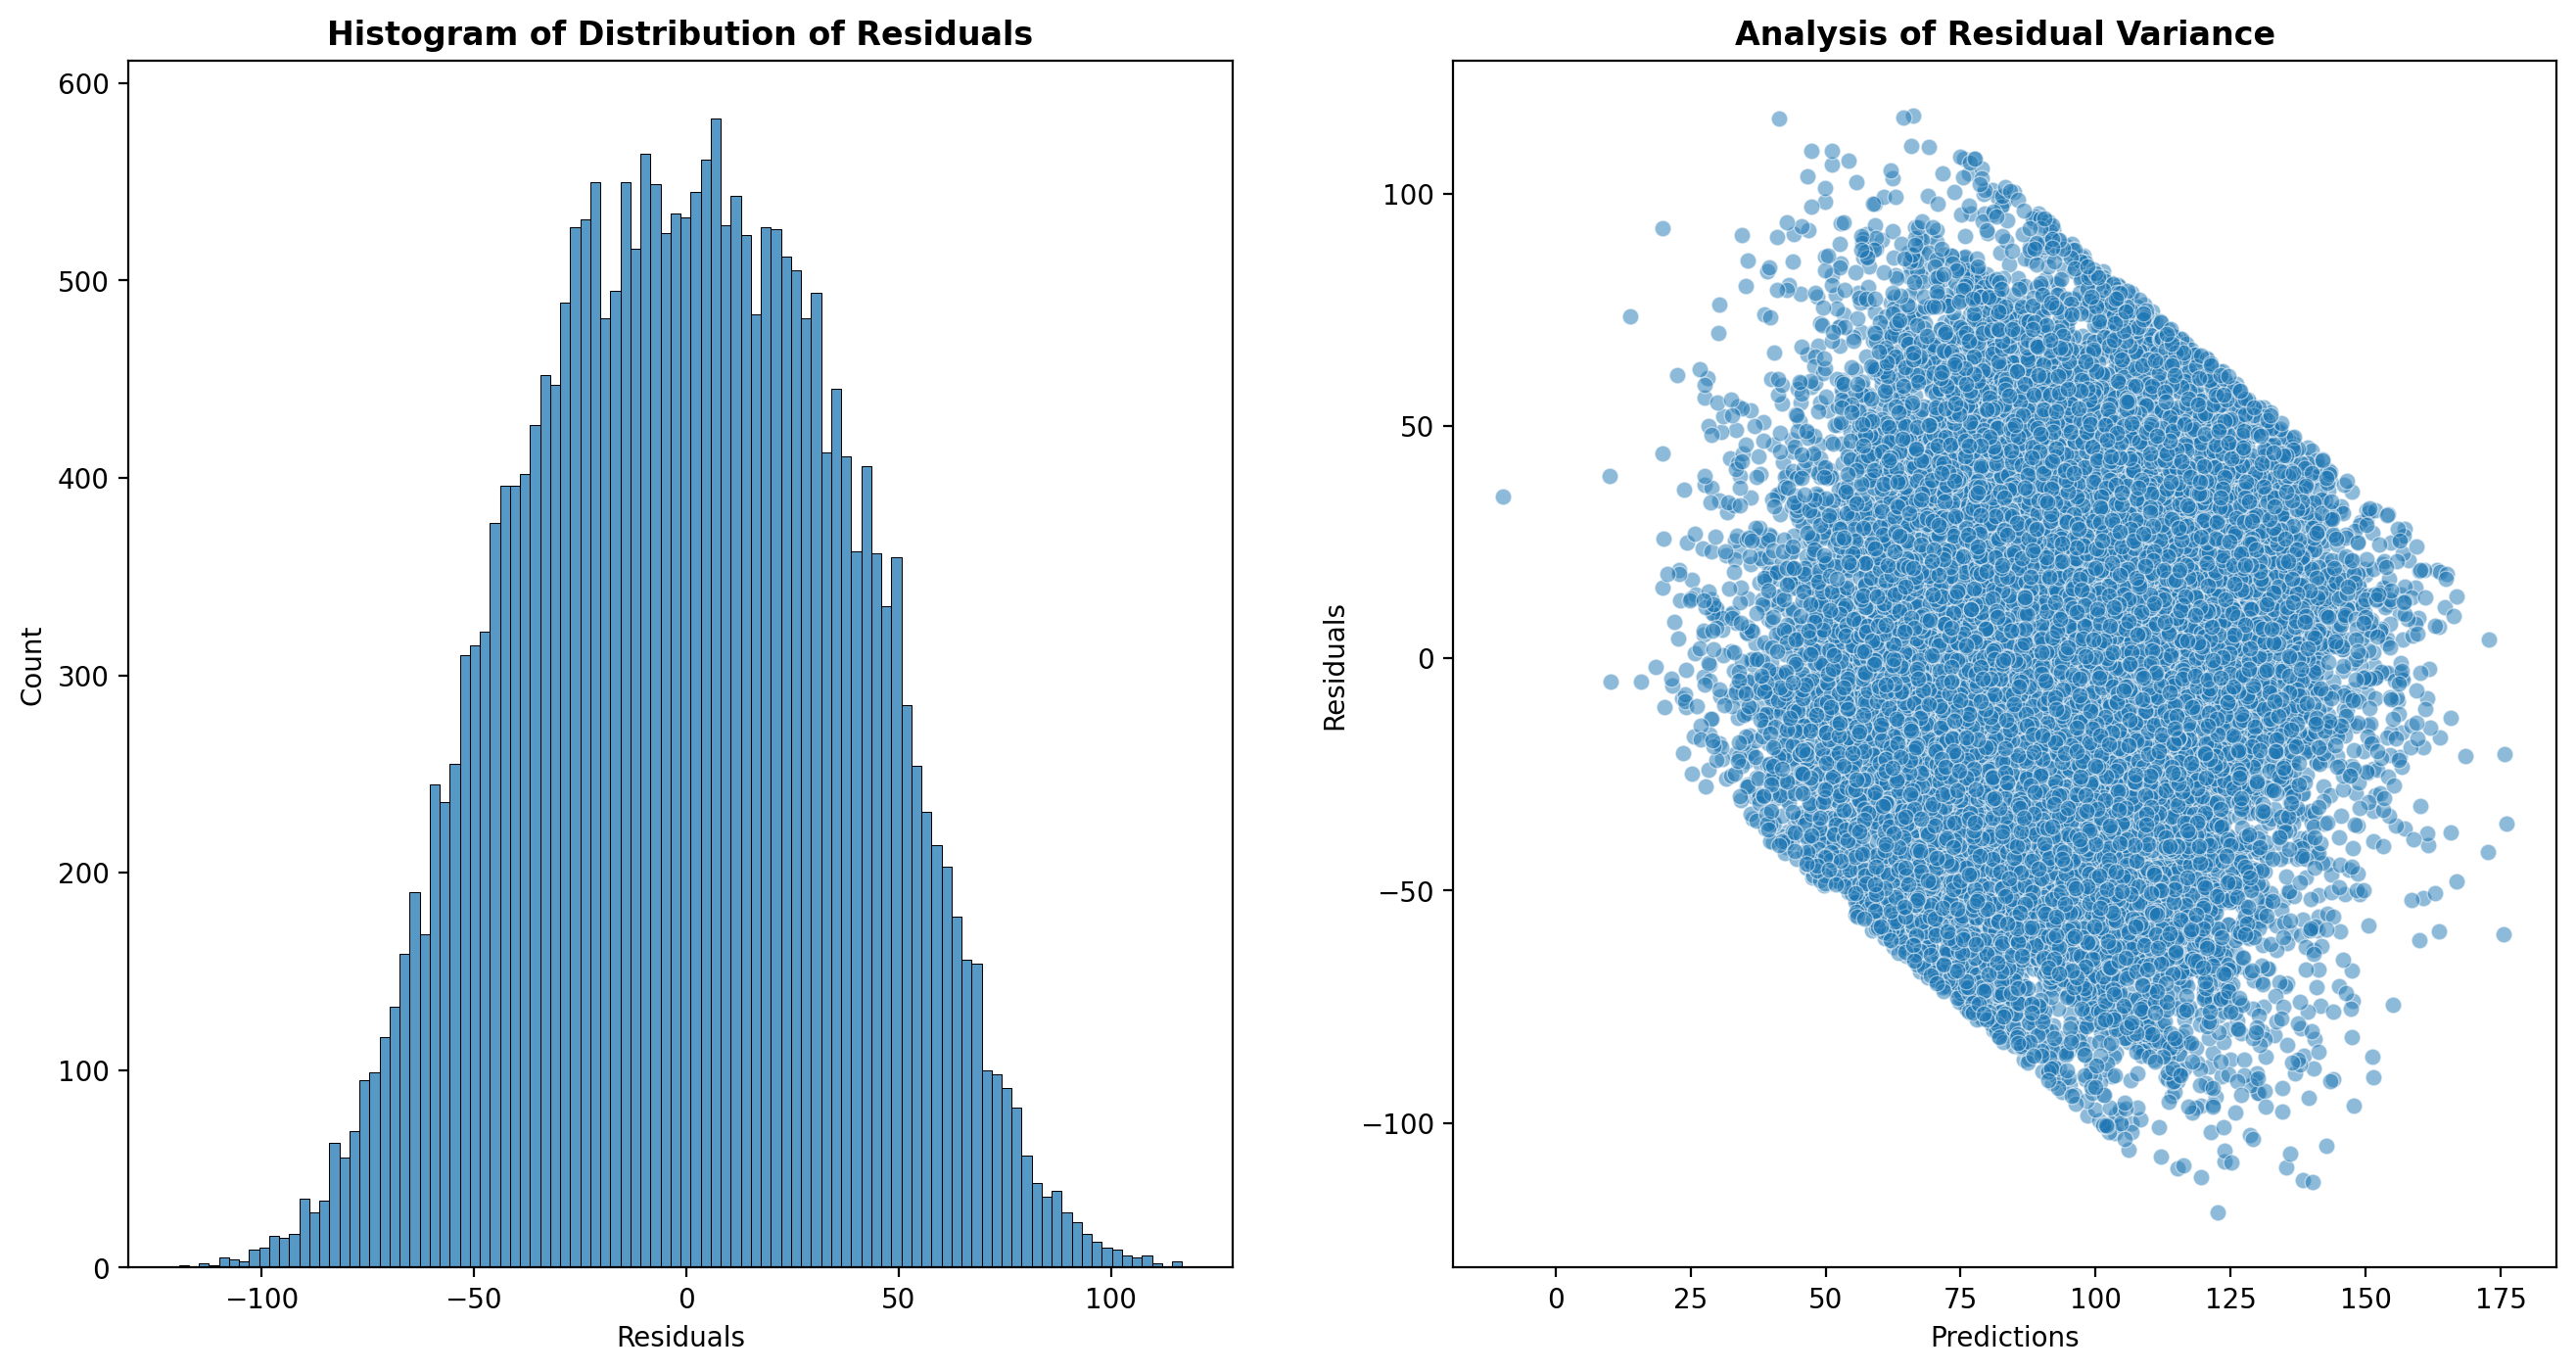

In [38]:
linear_regression_model(data1)

**Observations:**

The model did not achieve maximum quality, which could be due to the quality of the input data and suboptimal model selection. On average, the model makes an error of 37.81 units of crude oil. Residual analysis showed that the model consistently overestimates lower values of crude oil reserves and underestimates higher ones, resulting in the average predicted reserve being so close to the actual average reserve. The results of this model may be unreliable.

### Linear regression model for Region 2

Number of rows in training set: 74997
Number of rows in testing set: 24999 

RMSE (cross-validation) =  0.89
R2 (cross-validation) =  1.0 

RMSE (test) =  0.89
R2 (test) =  1.0 

Mean crude oil (real) 69.05
Mean crude oil (predicted) 69.04


product_true  product_pred
id                               
42gjK      3.179103      2.435587
zvuV8     26.953261     25.490599
NWHY3     53.906522     55.505843
HijQj     26.953261     27.401977
yHiJJ      0.000000      0.231574

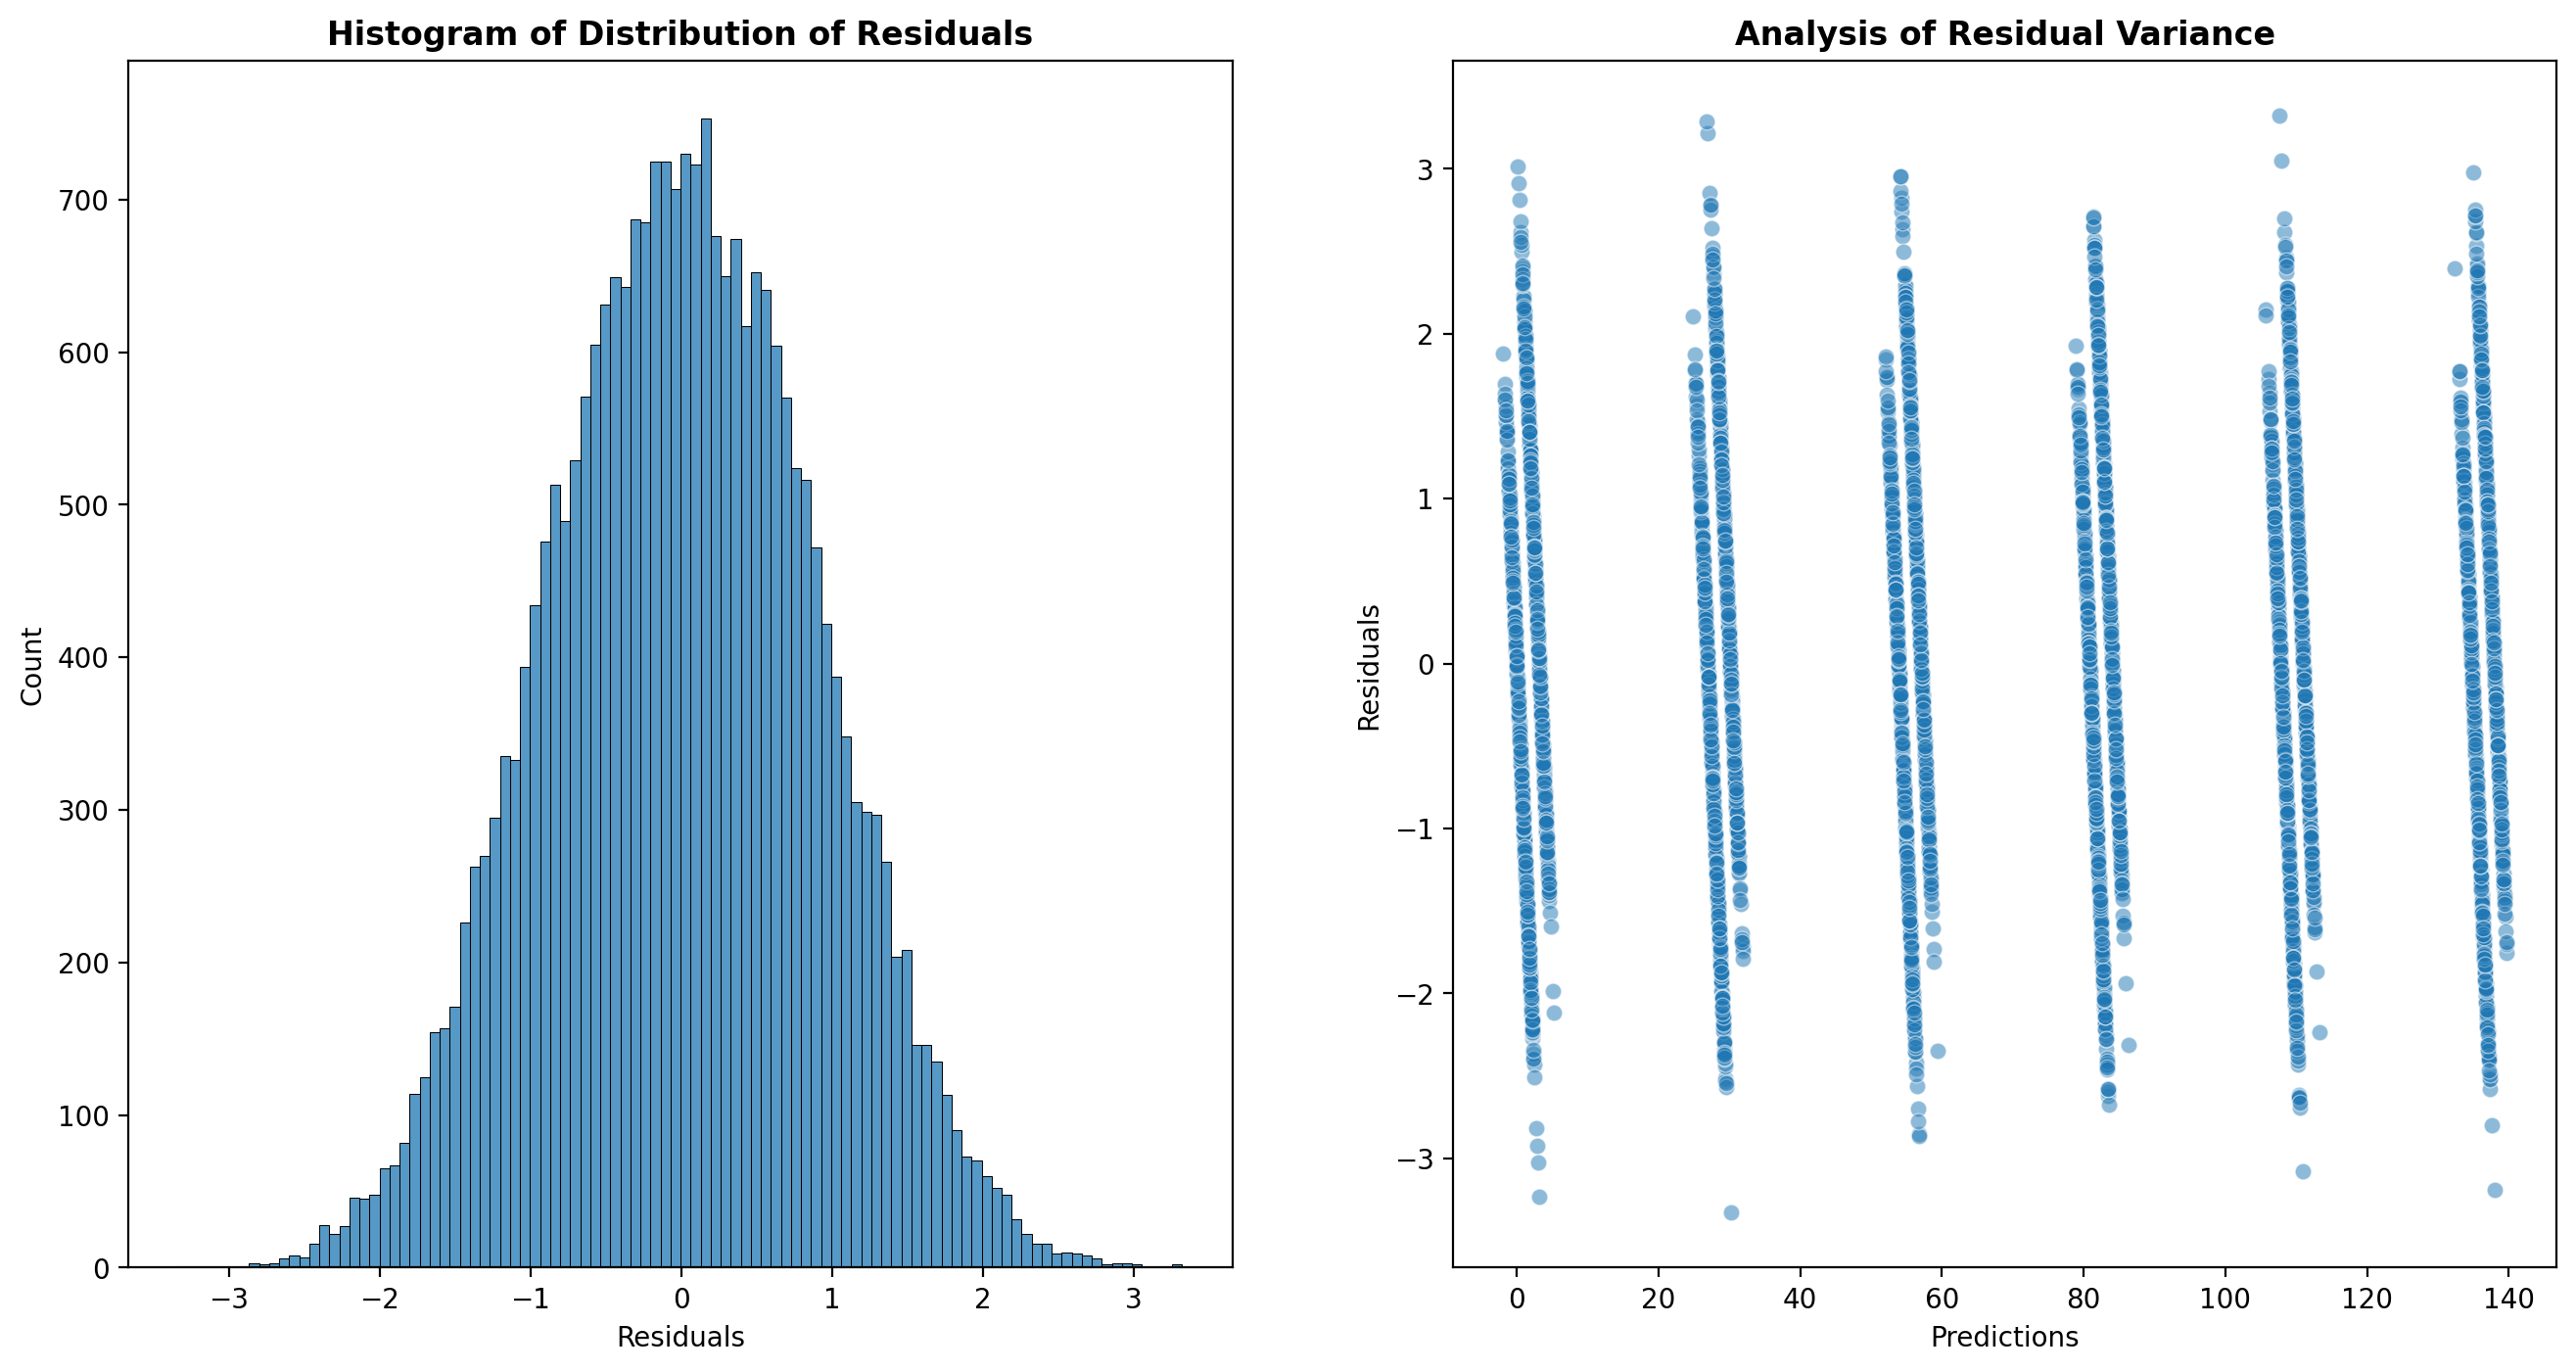

In [39]:
linear_regression_model(data2)

**Observations:** 

The model has achieved maximum quality, which could be attributed to the almost complete correlation between the target feature and feature `f2` in the second region. On average, the model makes an error of 0.89 units of crude oil. Residual analysis showed a normal distribution of residuals and constant variance, indicating that the results of this model are reliable.

### Linear regression model for Region 3

Number of rows in training set: 74997
Number of rows in testing set: 24999 

RMSE (cross-validation) =  40.03
R2 (cross-validation) =  0.2 

RMSE (test) =  40.14
R2 (test) =  0.2 

Mean crude oil (real) 94.82
Mean crude oil (predicted) 94.92


product_true  product_pred
id                               
wAtvR    131.922590     76.062691
nVhyX    165.456075     90.061111
ecze8    102.105539    120.630616
qju6o     34.079047     63.224541
FbzYP    138.077543    141.179707

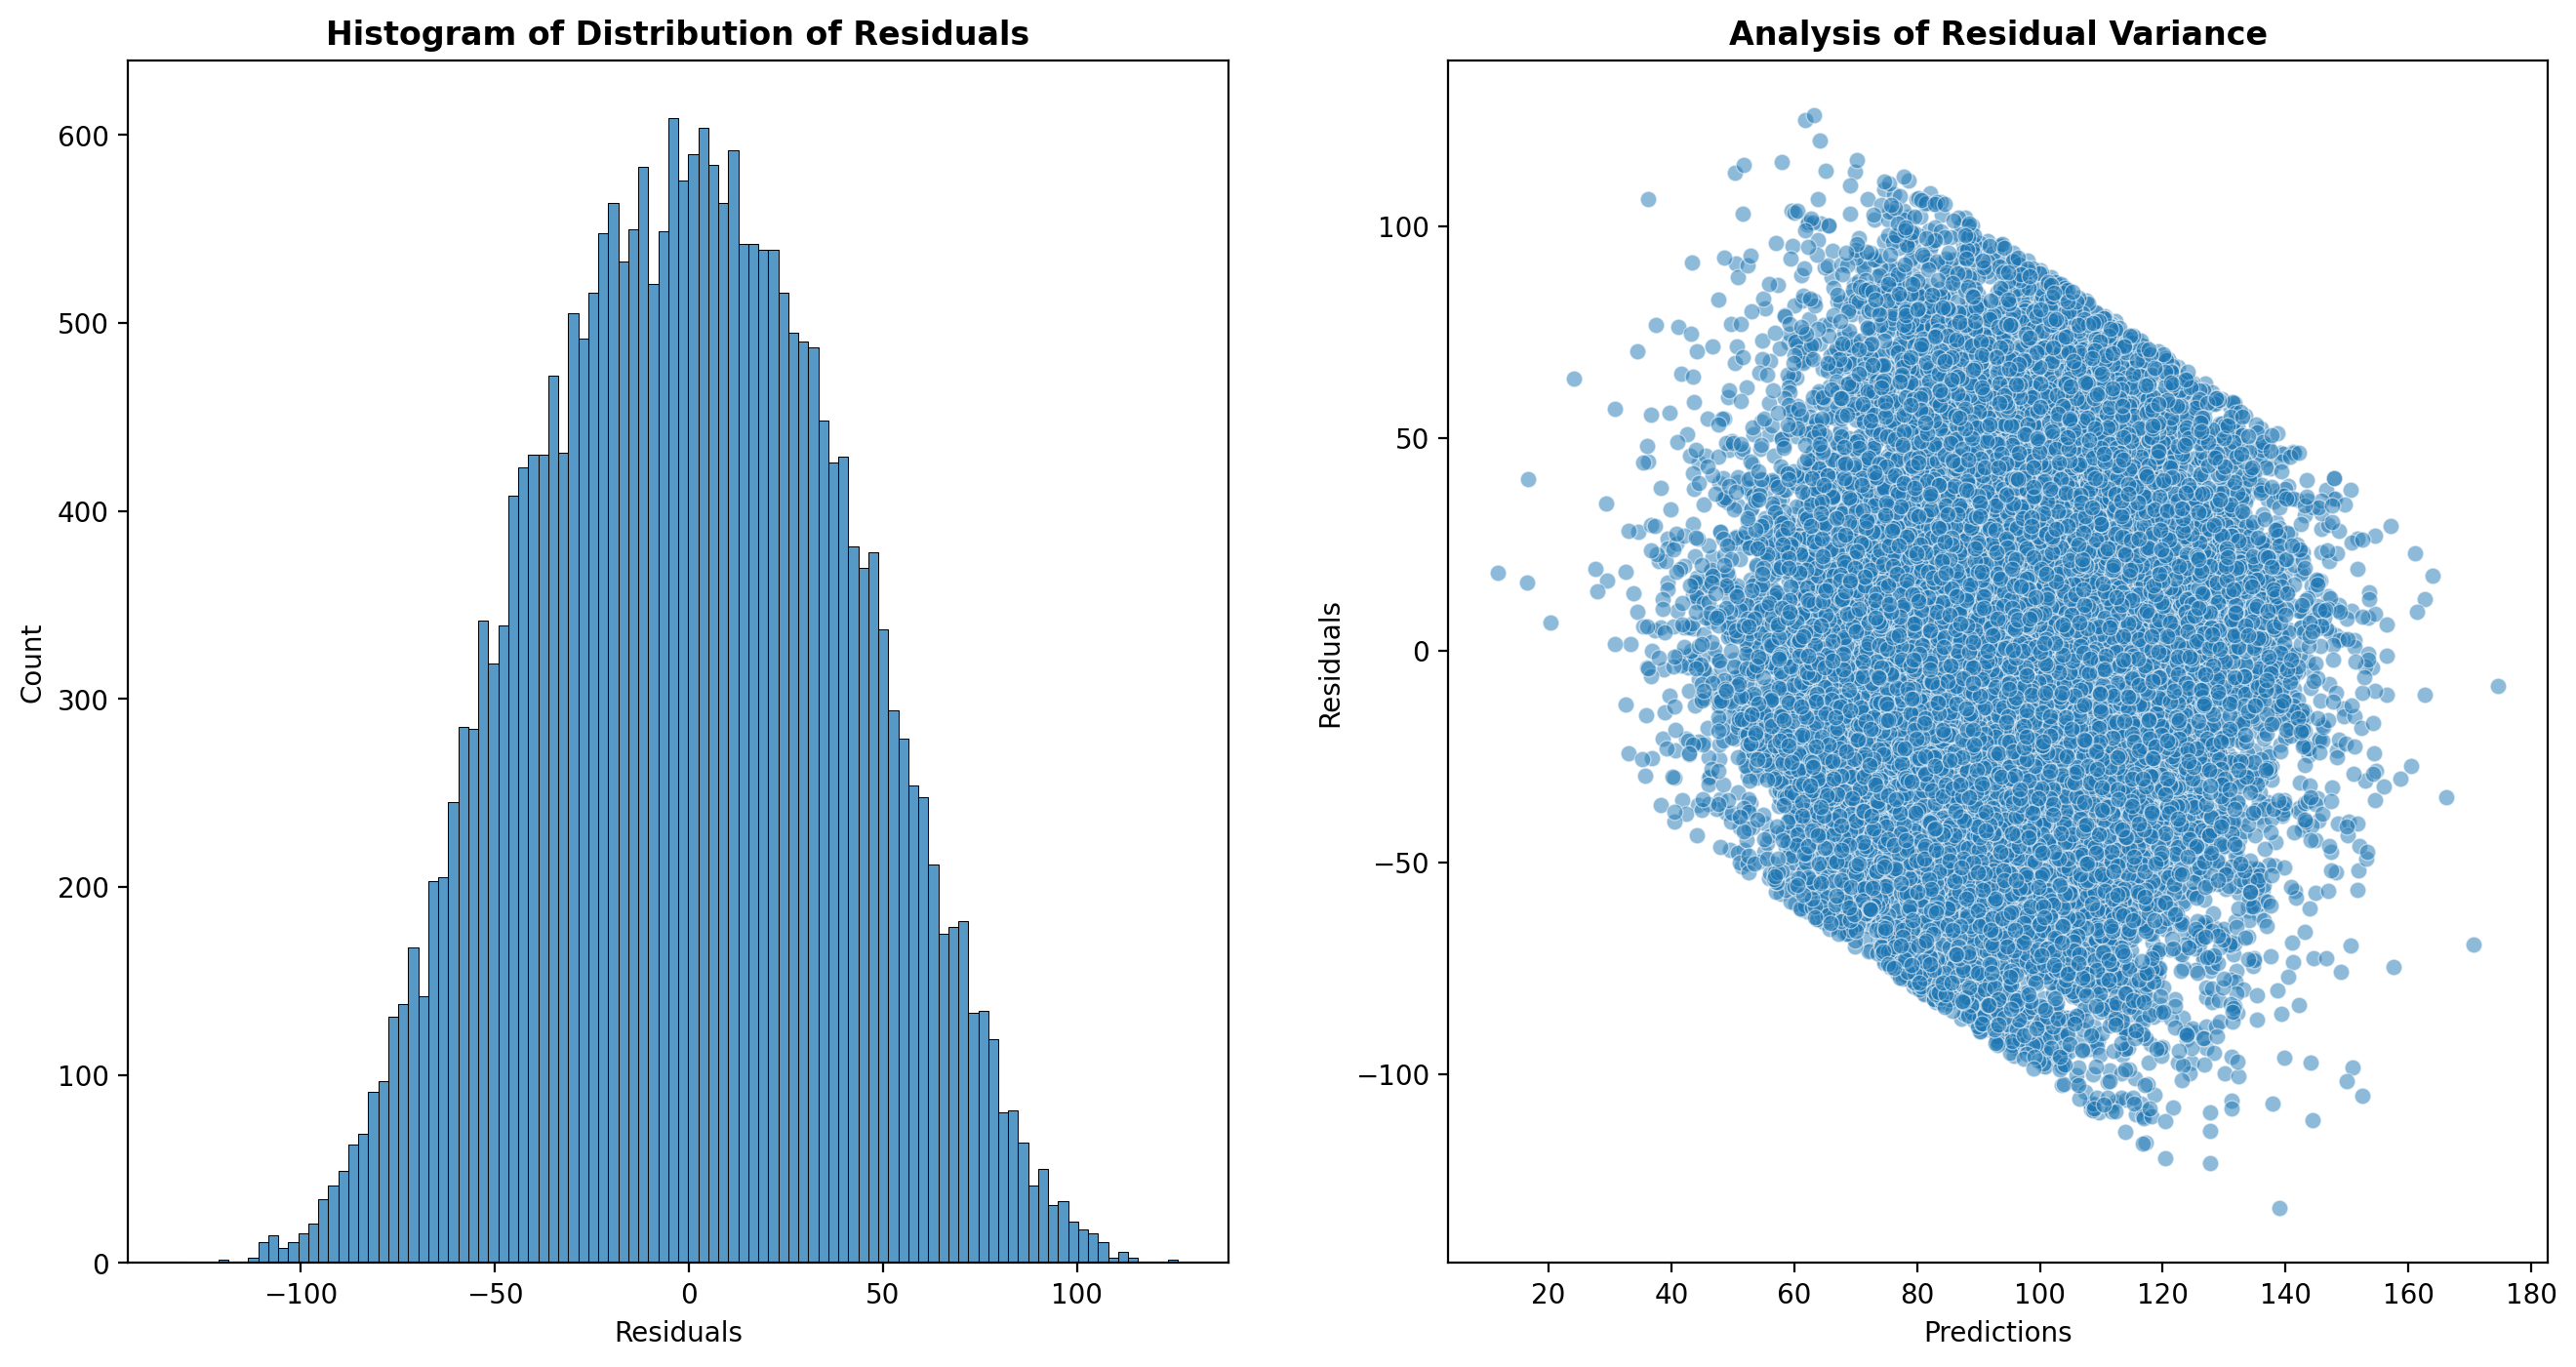

In [40]:
linear_regression_model(data3)

**Observations:**

The model did not achieve maximum quality, which could be due to the quality of the input data and suboptimal model selection. On average, the model makes an error of 40.14 units of crude oil. Similar to the first region, residual analysis showed that the model consistently overestimates lower values of crude oil reserves and underestimates higher values, resulting in the predicted average reserves being so close to the actual average reserves. The results of this model may be unreliable.

### Summary

Let's look at the pivot table with the metrics of all models.

In [41]:
models = pd.DataFrame({'region': ['Region 1', 'Region 2', 'Region 3'],
                       'rmse_train_cv': metrics_rmse_train,
                       'r2_train_cv': metrics_r2_train,
                       'rmse_valid': metrics_rmse_test,
                       'r2_valid': metrics_r2_test,
                       'mean_oil_true': mean_crude_oil_true,
                       'mean_oil_pred': mean_crude_oil_pred})
models

region  rmse_train_cv  r2_train_cv  rmse_valid  r2_valid  mean_oil_true  \
0  Region 1          37.66         0.28       37.81      0.28          92.22   
1  Region 2           0.89         1.00        0.89      1.00          69.05   
2  Region 3          40.03         0.20       40.14      0.20          94.82   

   mean_oil_pred  
0          92.37  
1          69.04  
2          94.92

The quality of the input data and the limitation in the choice of machine learning models have led to suboptimal model performance for the first and third regions. It is advisable to review the datasets; there might be errors in the data. Subsequently, models should be retrained on the new data. The quality of the model for the second region also raises doubts because of the almost complete correlation between the input and target features. There might be errors in the data as well.

## 5. Profit calculation and risk assessment

Earlier, we declared constants for profit calculation and risk assessment. Let's recall:

* The budget for well development in each region is 10 billion rubles (BUDGET).
* The profit from one unit of crude oil (1000 barrels) is 450 thousand rubles (PROFIT_PER_UNIT).
* The number of wells considered in the region is 200 (WELLS_COUNT).
* The maximum risk probability is 2.5% (RISK_LIMIT).
* To apply the Bootstrap technique, we will sample from 500 wells (BOOTSTRAP_SAMPLE_SIZE) and repeat it 1000 times (BOOTSTRAP_COUNT).

In [42]:
print(f'The crude oil reserve for break-even development should be at least \
{(BUDGET/PROFIT_PER_UNIT):.0f} units.')
print(f'Each of the {WELLS_COUNT} oil wells should contain an average of \
{(BUDGET/PROFIT_PER_UNIT/WELLS_COUNT):.0f} units of crude oil.')

The crude oil reserve for break-even development should be at least 22222 units.
Each of the 200 oil wells should contain an average of 111 units of crude oil.


For break-even development, the total crude oil reserve in the 200 oil wells should be at least 22 222 units (22 222 000 barrels of oil). Each well should contain an average of 111 units of product (111 000 barrels). Earlier, we calculated the average crude oil reserve in the wells of each region. In all three regions, the average crude oil reserve per well is below the break-even average level, but the total oil reserve meets the conditions.

To calculate profits and risks, we will apply the Bootstrap technique. In each iteration, we will randomly select 500 wells, then from these 500 wells, we will select the top 200 wells with the highest crude oil reserves predicted by the machine learning model. After that, we will calculate the profit from these 200 oil wells based on the true values. We will repeat these steps 1000 times and output the average profit, a 95% confidence interval for the profit, and an estimate of the risk of loss.

Let's create variables to store the results of the Bootstrap procedure and a function to execute it.

In [43]:
# Variables for Bootstrap results
metric_mean_profit = []
metric_quantile_lower = []
metric_quantile_upper = []
metric_risk = []
metric_risk_evaluation = []

state = np.random.RandomState(seed=RANDOM_STATE)

In [44]:
# Function for profit calculation (in billions rubles)
def calculate_profit_millions(bootstrap_data):
    bootstrap_data = bootstrap_data.sort_values(by='product_pred', ascending=False).head(WELLS_COUNT)
    revenue = (bootstrap_data['product_true'].sum() * PROFIT_PER_UNIT)
    return (revenue - BUDGET) / 1e6

In [45]:
# Function for Bootstrap
def run_bootstrap(data):
    profit = []
    for i in range(BOOTSTRAP_COUNT):
        sample = data.sample(n=BOOTSTRAP_SAMPLE_SIZE,
                             replace=True,
                             random_state=state)
        profit.append(calculate_profit_millions(sample))
    profit = pd.Series(profit)
    quantile_lower = profit.quantile((1 - INTERVAL) / 2).round(0)
    quantile_upper = profit.quantile((1 + INTERVAL) / 2).round(0)
    mean_profit = profit.mean().round(0)
    loss_count = 0
    for p in range(len(profit)):
        if profit[p] < 0:
            loss_count += 1
    risk_percent = (loss_count / BOOTSTRAP_COUNT) * 100
    print('Mean profit, million rubles:', mean_profit)
    print(f'{((1 - INTERVAL) / 2):.1%}-quantile: {quantile_lower}')
    print(f'{((1 + INTERVAL) / 2):.1%}-quantile: {quantile_upper}')
    print(f'Loss probability {risk_percent:.2}%')
    if risk_percent <= RISK_LIMIT*100:
        print('Loss risk probability requirement has been met.')
        metric_risk_evaluation.append('Yes')
    else:
        print('Loss risk probability requirement has not been met.')
        metric_risk_evaluation.append('No')
    metric_mean_profit.append(mean_profit)
    metric_quantile_lower.append(quantile_lower)
    metric_quantile_upper.append(quantile_upper)
    metric_risk.append(risk_percent)

Let's apply Bootstrap for Region 1.

In [46]:
run_bootstrap(data=bootstrap_data[0])

Mean profit, million rubles: 393.0
2.5%-quantile: -98.0
97.5%-quantile: 929.0
Loss probability 5.7%
Loss risk probability requirement has not been met.


The mean profit will be 393 million rubles, with a 95% probability that the true value of the mean profit will be in the range from -98 to 929 million rubles. The probability of loss is 5.7%, which does not meet the criteria (the loss risk should be less than 2.5%).

Let's repeat the same actions for Region 2.

In [47]:
run_bootstrap(data=bootstrap_data[1])

Mean profit, million rubles: 454.0
2.5%-quantile: 54.0
97.5%-quantile: 859.0
Loss probability 1.2%
Loss risk probability requirement has been met.


The mean profit will be 454 million rubles, with a 95% probability that the true value of the mean profit will be in the range from 54 to 859 million rubles. The probability of loss is 1.2%, which meets the criteria (the loss risk should be less than 2.5%).

Let's repeat the same actions for Region 3.

In [48]:
run_bootstrap(data=bootstrap_data[2])

Mean profit, million rubles: 361.0
2.5%-quantile: -149.0
97.5%-quantile: 840.0
Loss probability 9.1%
Loss risk probability requirement has not been met.


The mean profit will be 361 million rubles, with a 95% probability that the true value of the mean profit will be in the range from -149 to 840 million rubles. The probability of loss is 9.1%, which does not meet the criteria (the loss risk should be less than 2.5%).

In [49]:
final_table = pd.DataFrame({'Region': ['Region 1', 'Region 2', 'Region 3'],
                            'Mean profit, million rubles': metric_mean_profit,
                            'Lower bound of CI, million rubles': metric_quantile_lower,
                            'Upper bound of CI, million rubles': metric_quantile_upper,
                            'Loss probability, %': metric_risk,
                            'Met risk criteria': metric_risk_evaluation})

## 6. Research conclusion

In this research, we worked with data on oil wells in three regions of Russia. Linear regression models were used to predict crude oil reserves.

* The average crude oil reserve in wells in the first region is 92.37 units of product.
* The average crude oil reserve in wells in the second region is 69.04 units of product.
* The average crude oil reserve in wells in the third region is 94.92 units of product.

The table below presents calculations of average profit and loss risk estimates.

In [50]:
final_table

Region  Mean profit, million rubles  Lower bound of CI, million rubles  \
0  Region 1                        393.0                              -98.0   
1  Region 2                        454.0                               54.0   
2  Region 3                        361.0                             -149.0   

   Upper bound of CI, million rubles  Loss probability, % Met risk criteria  
0                              929.0                  5.7                No  
1                              859.0                  1.2               Yes  
2                              840.0                  9.1                No

Despite the fact that the average crude oil reserves in the second region are lower than in the first and third, the expected average profit of 454 million rubles is higher than in the other regions, with a 95% probability the true value of the average profit will be in the range from 54 to 859 million rubles, and the loss risks are 1.2%, which meets the customer's requirements (loss risk less than 2.5%). It is also worth noting that the quality of the machine learning model for the second region was significantly higher than the quality of the models for the other regions, which allows us to be confident in the predicted values.

**Final conclusion:** it is recommended to start development in region number 2.